In [1]:
import os
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import glob
from tqdm import tqdm
from pathlib import Path
import json
import random


In [2]:
dataset_path = '/datasets/ricordi'

In [3]:
def data_json(dataset_path):
    dataset = []
    # iterate through all folders in the directory
    for folder in glob.glob(dataset_path + '/*'):
        for files in glob.glob(folder + '/*'):
            # check if the file is either a folder or a json file
            if os.path.isdir(files):
                for data_path in glob.glob(files + '/*'):
                    dataset.append(glob.glob(data_path + '/*.json'))
            elif files.endswith('.json'):
                dataset.append(files)
    dataset = list(flatten(dataset))
    print("Total json files:", len(dataset))
    return dataset

In [4]:
def sort_by_key(data,key):
    dataset = []
    for i in data:
        f = open(i)
        json_data = json.load(f)
        if key in json_data:
            dataset.append(i)
        else:
            continue
    print("Json with annotazione1 present:",len(dataset))
    return dataset

In [5]:
dmerge_classes = [[2, 15], [7, 9]]
classes_relevant = [5,6,7,8,9,10,11,12,14,16]
classes_irrelevant = [0,1,2,3,4,15,17]
classes = classes_relevant + classes_irrelevant

# Define the class names in the same order as the classes list
class_names_relevant = [
    "Pause (full or almost)",
    "Single note (with at least the head)",
    "Multiple Notes (with at least the head)",
    "Single chord (with at least heads)",
    "Multiple chords (with at least heads)",
    "Accidental(s) (whole or nearly so)",
    "Key(s) (whole(s) or nearly)",
    "Embellishment(s) (whole(s) or nearly)",
    "More categories (with at least one musical sign)",
    "Other (with at least one musical sign)"
]

class_names_irrelevant = [
    "Page border",
    "Erasure",
    "Blurr",
    "Printed Text",
    "Manuscript Text",
    "More categories (no musical signs)",
    "Other (without musical markings)"
]

# Combine the relevant and irrelevant class names
class_names = class_names_relevant + class_names_irrelevant

In [6]:
json_list = data_json(dataset_path)
sorted_list_by_key = sort_by_key(json_list, "annotazione1")

Total json files: 469590


Json with annotazione1 present: 196639


In [7]:
def plot_distribution_by_class(sorted_list_by_key, classes, key):
    count = {i: 0 for i in classes}
    
    for i in sorted_list_by_key:
        with open(i) as f:
            json_data = json.load(f)
            class_index = json_data[key]
            count[class_index] += 1
    
    print(count)

    # reorder classes, relevant first
    count = [count[i] for i in classes_relevant] + [count[i] for i in classes_irrelevant]
    labels = ["Relevant"] + [None] * (len(classes_relevant) - 1) + ["Irrelevant"] + [None] * (len(classes_irrelevant) - 1)
    colors = ["tab:red" for _ in classes_relevant] + ["tab:blue" for _ in classes_irrelevant]
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.rcParams.update({'font.size': 8})
    plt.bar(x, count, label=labels, color=colors)
    plt.xticks(x, class_names, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.legend()
    plt.show()

    return count

{5: 316, 6: 2998, 7: 5621, 8: 975, 9: 818, 10: 2206, 11: 3370, 12: 779, 14: 9039, 16: 1173, 0: 118966, 1: 10370, 2: 13052, 3: 4246, 4: 12501, 15: 1443, 17: 8766}


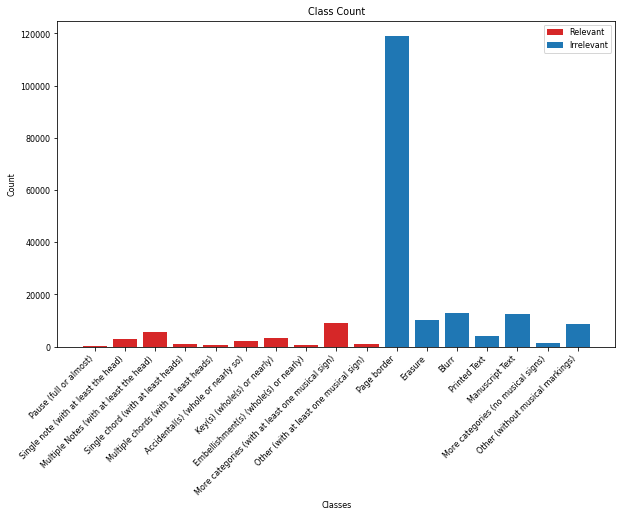

In [8]:
count = plot_distribution_by_class(sorted_list_by_key,classes, "annotazione1")

In [9]:
# Merge classes that have cardinality < 0.5 of median cardinality
merged = []
m = np.median(count)
print("Median is", m)
print("Mean is", np.mean(count))
print("Min is", np.min(count))

# note, we force classes 9 and 7 and classes 15 and 2 to look like if they the same number of samples 
# (the sum of the two) so that they are appended to `merged` together
count_ = np.copy(count)
count_[9] += count_[7]
count_[15] += count_[2]
count_[7] = count_[9]
count_[2] = count_[15]

for i, c in enumerate(count_):
    if c < 0.75 * m:
        merged.append(i)

print("Merging classes:", [class_names[i] for i in merged])
print("Total of `Remaining` class: ", sum(count_[c] for c in merged if c not in [15, 9]))

Median is 3370.0
Mean is 11567.0
Min is 316
Merging classes: ['Pause (full or almost)', 'Single chord (with at least heads)', 'Multiple chords (with at least heads)', 'Accidental(s) (whole or nearly so)', 'Embellishment(s) (whole(s) or nearly)', 'Other (with at least one musical sign)']
Total of `Remaining` class:  6267


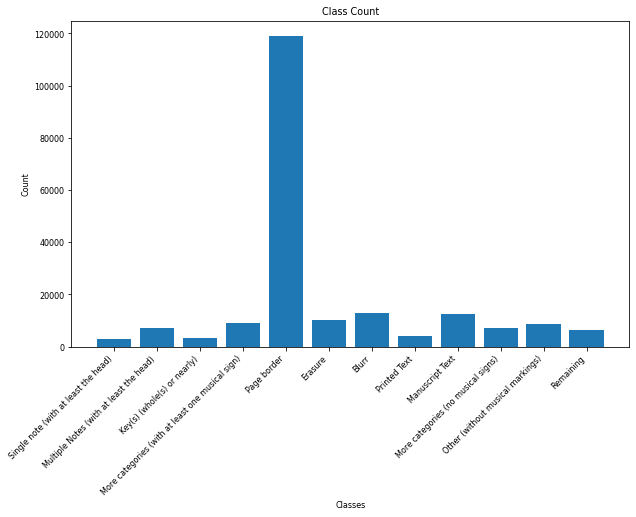

Median now is 7915.0
Mean now is 16975.25
Min now is 2998
Cardinalities: [('Single note (with at least the head)', 2998), ('Multiple Notes (with at least the head)', 7064), ('Key(s) (whole(s) or nearly)', 3370), ('More categories (with at least one musical sign)', 9039), ('Page border', 118966), ('Erasure', 10370), ('Blurr', 13052), ('Printed Text', 4246), ('Manuscript Text', 12501), ('More categories (no musical signs)', 7064), ('Other (without musical markings)', 8766), ('Remaining', 6267)]


In [10]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

count__ = [count_[i] for i in range(len(class_names)) if i not in merged]
count__.append(sum([count_[c] for c in merged if c not in [15, 9]]))
class_names_ = [class_names[i] for i in range(len(class_names)) if i not in merged]
class_names_.append("Remaining")

x = np.arange(len(class_names_))  # Generate an array of class indices
plt.rcParams.update({'font.size': 8})
plt.bar(x, count__) # , label=labels, color=colors)
plt.xticks(x, class_names_, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Count")
plt.show()
print("Median now is", np.median(count__))
print("Mean now is", np.mean(count__))
print("Min now is", np.min(count__))
print("Cardinalities:", list(zip(class_names_, count__)))

In [11]:
from pathlib import Path

source_dataset_path = Path('./data/source/')
binary_dataset_path = Path('./data/binary_dataset')
relevant_path = binary_dataset_path / 'data' / 'relevant'
irrelevant_path = binary_dataset_path / 'data' / 'irrelevant'
source_dataset_path.mkdir(exist_ok=True, parents=True)
relevant_path.mkdir(exist_ok=True, parents=True)
irrelevant_path.mkdir(exist_ok=True, parents=True)
multiclass_dataset_path = Path('./data/multiclass_dataset') / 'data'

In [12]:
from shutil import copyfile

# copy all relevant images to both datasets
for json_file in tqdm(Path(dataset_path).glob("**/*.json")):
    with open(json_file, 'r') as f:
        data = json.load(f)
        if "annotazione1" in data:
            label = int(data["annotazione1"])
            png_path = Path(data["path"][18:])
            # compute the name of the physical copy
            copied_path = source_dataset_path / png_path
            # copy the file
            copied_path.parent.mkdir(exist_ok=True, parents=True)
            copyfile(dataset_path / png_path, copied_path)
            
            # symlink into the binary dataset
            if label in classes_irrelevant:
                binary_path = irrelevant_path / png_path.name
            elif label in classes_relevant:
                binary_path = relevant_path / png_path.name
            else:
                print("Unknown label!")
            target = os.path.relpath(copied_path, start=binary_path.parent)
            binary_path.symlink_to(target)
            
            # symlink to the multiclass dataset
            # N.B. handle merged classes
            if label in merged:
                class_name = "Remaining"
            elif label in [9, 7]:
                class_name = "Multiple notes or chords"
            elif label in [15, 2]:
                class_name = "Blurr or multiple categories (no music signs)"
            else:
                class_name = class_names[classes.index(label)]
            class_path = multiclass_dataset_path / class_name
            class_path.mkdir(exist_ok=True, parents=True)
            multiclass_name = (class_path / png_path.name)
            # note relative_to doesn't work for an issue in python 3.9 https://bugs.python.org/issue40358
            target = os.path.relpath(copied_path, start=multiclass_name.parent)
            multiclass_name.symlink_to(target)

0it [00:00, ?it/s]

776it [00:00, 7757.60it/s]

1552it [00:00, 5734.71it/s]

2157it [00:00, 4887.85it/s]

2718it [00:00, 5113.03it/s]

3261it [00:00, 5208.93it/s]

3829it [00:00, 5349.07it/s]

4668it [00:00, 6273.40it/s]

5310it [00:00, 6114.65it/s]

5932it [00:01, 5347.29it/s]

6489it [00:01, 5365.06it/s]

7044it [00:01, 5415.61it/s]

7605it [00:01, 5465.67it/s]

8160it [00:01, 5432.74it/s]

8709it [00:01, 5382.45it/s]

9252it [00:01, 5364.23it/s]

9792it [00:01, 4778.92it/s]

10283it [00:01, 4615.64it/s]

10850it [00:02, 4897.78it/s]

11403it [00:02, 5072.73it/s]

12024it [00:02, 5393.88it/s]

12578it [00:02, 5432.67it/s]

13127it [00:02, 5439.17it/s]

13748it [00:02, 5664.63it/s]

14318it [00:02, 5377.24it/s]

14861it [00:02, 5247.40it/s]

15390it [00:02, 5219.06it/s]

15929it [00:02, 5265.56it/s]

16649it [00:03, 5825.45it/s]

17235it [00:03, 5614.37it/s]

17800it [00:03, 5621.33it/s]

18365it [00:03, 5518.33it/s]

18919it [00:03, 5441.65it/s]

19820it [00:03, 6471.23it/s]

20472it [00:03, 6213.44it/s]

21099it [00:03, 5681.69it/s]

21679it [00:03, 5619.21it/s]

22249it [00:04, 5527.05it/s]

22807it [00:04, 5489.61it/s]

23360it [00:04, 5372.41it/s]

23903it [00:04, 5385.03it/s]

24444it [00:04, 4906.51it/s]

24943it [00:04, 4622.77it/s]

25487it [00:04, 4839.93it/s]

26067it [00:04, 5100.66it/s]

26585it [00:04, 4872.66it/s]

27079it [00:05, 4575.09it/s]

27612it [00:05, 4778.08it/s]

28106it [00:05, 4819.90it/s]

28657it [00:05, 5012.50it/s]

29182it [00:05, 5081.05it/s]

29914it [00:05, 5730.18it/s]

30492it [00:05, 5579.71it/s]

31054it [00:05, 5546.87it/s]

31612it [00:05, 5471.17it/s]

32161it [00:06, 5399.21it/s]

32703it [00:06, 5362.84it/s]

33241it [00:06, 5280.92it/s]

33770it [00:06, 4788.73it/s]

34258it [00:06, 4677.51it/s]

34872it [00:06, 5076.66it/s]

35402it [00:06, 5137.47it/s]

35922it [00:06, 5097.30it/s]

36440it [00:06, 5120.84it/s]

37021it [00:06, 5321.45it/s]

37565it [00:07, 5355.78it/s]

38218it [00:07, 5698.64it/s]

38790it [00:07, 5566.70it/s]

39349it [00:07, 4950.63it/s]

39858it [00:07, 4882.84it/s]

40356it [00:07, 4673.78it/s]

41046it [00:07, 5278.16it/s]

41585it [00:07, 5245.70it/s]

42133it [00:07, 5311.92it/s]

42670it [00:08, 5261.72it/s]

43209it [00:08, 5297.40it/s]

43742it [00:08, 5229.92it/s]

44268it [00:08, 4913.60it/s]

44765it [00:08, 4729.90it/s]

45242it [00:08, 4066.49it/s]

45666it [00:08, 3972.63it/s]

46188it [00:08, 4295.38it/s]

46704it [00:08, 4525.62it/s]

47213it [00:09, 4682.69it/s]

47767it [00:09, 4926.70it/s]

48268it [00:09, 4892.41it/s]

48965it [00:09, 5491.16it/s]

49520it [00:09, 5033.61it/s]

50035it [00:09, 5017.21it/s]

50592it [00:09, 5171.58it/s]

51227it [00:09, 5507.17it/s]

51784it [00:09, 5288.20it/s]

52319it [00:10, 5185.28it/s]

52842it [00:10, 5163.04it/s]

53477it [00:10, 5498.52it/s]

54031it [00:10, 5488.00it/s]

54583it [00:10, 4836.22it/s]

55082it [00:10, 4864.00it/s]

55753it [00:10, 5372.02it/s]

56302it [00:10, 5351.31it/s]

56846it [00:10, 5252.46it/s]

57378it [00:11, 4893.04it/s]

57876it [00:11, 4261.76it/s]

58320it [00:11, 3916.45it/s]

58727it [00:11, 3416.59it/s]

59087it [00:11, 3159.25it/s]

59416it [00:11, 2859.70it/s]

59712it [00:11, 2746.53it/s]

60193it [00:11, 3238.45it/s]

60534it [00:12, 2866.51it/s]

60838it [00:12, 2751.07it/s]

61125it [00:12, 2622.66it/s]

61395it [00:12, 2527.54it/s]

61653it [00:12, 2536.69it/s]

61914it [00:12, 2555.03it/s]

62172it [00:12, 2508.57it/s]

62425it [00:12, 2474.13it/s]

62674it [00:13, 2468.61it/s]

62922it [00:13, 2470.58it/s]

63170it [00:13, 2318.42it/s]

63587it [00:13, 2829.66it/s]

63875it [00:13, 2502.31it/s]

64135it [00:13, 2428.53it/s]

64385it [00:13, 2287.92it/s]

64619it [00:13, 2290.47it/s]

64853it [00:13, 2301.05it/s]

65086it [00:14, 2277.56it/s]

65470it [00:14, 2715.51it/s]

65747it [00:14, 2727.27it/s]

66023it [00:14, 2641.71it/s]

66290it [00:14, 2600.50it/s]

66552it [00:14, 2584.09it/s]

66812it [00:14, 2510.70it/s]

67065it [00:14, 2491.98it/s]

67316it [00:14, 2496.25it/s]

67567it [00:15, 2424.91it/s]

67811it [00:15, 2324.21it/s]

68066it [00:15, 2383.04it/s]

68582it [00:15, 3175.06it/s]

68904it [00:15, 2888.11it/s]

69201it [00:15, 2776.66it/s]

69485it [00:15, 2721.08it/s]

69761it [00:15, 2647.35it/s]

70029it [00:15, 2420.86it/s]

70276it [00:16, 2362.64it/s]

70534it [00:16, 2419.83it/s]

70786it [00:16, 2446.97it/s]

71062it [00:16, 2532.38it/s]

71318it [00:16, 2536.79it/s]

71574it [00:16, 2521.16it/s]

71828it [00:16, 2478.75it/s]

72096it [00:16, 2537.03it/s]

72483it [00:16, 2921.08it/s]

72777it [00:16, 2769.19it/s]

73057it [00:17, 2743.29it/s]

73333it [00:17, 2704.93it/s]

73605it [00:17, 2627.15it/s]

73869it [00:17, 2622.42it/s]

74132it [00:17, 2460.38it/s]

74389it [00:17, 2485.51it/s]

74640it [00:17, 2375.28it/s]

74880it [00:17, 2355.75it/s]

75333it [00:17, 2966.09it/s]

75634it [00:18, 2635.13it/s]

75907it [00:18, 2410.36it/s]

76157it [00:18, 2291.36it/s]

76416it [00:18, 2363.63it/s]

76658it [00:18, 2347.36it/s]

76897it [00:18, 2290.50it/s]

77129it [00:18, 2172.32it/s]

77349it [00:18, 1977.93it/s]

77551it [00:19, 1823.38it/s]

77738it [00:19, 1708.93it/s]

77912it [00:19, 1494.62it/s]

78067it [00:19, 1496.40it/s]

78221it [00:19, 1458.64it/s]

78370it [00:19, 1459.40it/s]

78594it [00:19, 1663.27it/s]

78764it [00:19, 1571.78it/s]

78924it [00:20, 1417.09it/s]

79070it [00:20, 1420.54it/s]

79262it [00:20, 1554.26it/s]

79432it [00:20, 1591.39it/s]

79594it [00:20, 1480.35it/s]

79746it [00:20, 1412.91it/s]

79890it [00:20, 1322.96it/s]

80025it [00:20, 1283.91it/s]

80158it [00:20, 1296.19it/s]

80289it [00:21, 1286.32it/s]

80462it [00:21, 1406.96it/s]

80604it [00:21, 1289.60it/s]

80768it [00:21, 1384.28it/s]

80914it [00:21, 1402.48it/s]

81057it [00:21, 1345.66it/s]

81206it [00:21, 1384.24it/s]

81346it [00:21, 1315.29it/s]

81480it [00:21, 1264.44it/s]

81611it [00:22, 1275.33it/s]

81748it [00:22, 1298.01it/s]

81879it [00:22, 1251.38it/s]

82022it [00:22, 1297.28it/s]

82160it [00:22, 1315.40it/s]

82293it [00:22, 1315.62it/s]

82456it [00:22, 1403.01it/s]

82754it [00:22, 1863.98it/s]

82942it [00:22, 1613.83it/s]

83111it [00:23, 1511.16it/s]

83273it [00:23, 1538.09it/s]

83431it [00:23, 1539.74it/s]

83588it [00:23, 1411.29it/s]

83733it [00:23, 1393.28it/s]

83875it [00:23, 1377.85it/s]

84049it [00:23, 1474.28it/s]

84199it [00:23, 1453.25it/s]

84346it [00:23, 1392.03it/s]

84487it [00:24, 1324.67it/s]

84626it [00:24, 1338.06it/s]

84761it [00:24, 1267.59it/s]

84899it [00:24, 1297.85it/s]

85207it [00:24, 1800.05it/s]

85391it [00:24, 1691.59it/s]

85565it [00:24, 1544.17it/s]

85725it [00:24, 1526.72it/s]

85881it [00:24, 1470.99it/s]

86031it [00:25, 1475.20it/s]

86181it [00:25, 1449.60it/s]

86329it [00:25, 1453.04it/s]

86479it [00:25, 1462.92it/s]

86626it [00:25, 1437.70it/s]

86782it [00:25, 1469.82it/s]

86938it [00:25, 1488.43it/s]

87210it [00:25, 1842.19it/s]

87396it [00:25, 1531.12it/s]

87559it [00:26, 1436.60it/s]

87710it [00:26, 1388.36it/s]

87862it [00:26, 1418.32it/s]

88008it [00:26, 1377.11it/s]

88149it [00:26, 1369.83it/s]

88288it [00:26, 1331.29it/s]

88453it [00:26, 1415.58it/s]

88597it [00:26, 1319.45it/s]

88731it [00:26, 1274.93it/s]

88895it [00:27, 1370.99it/s]

89035it [00:27, 1305.91it/s]

89168it [00:27, 1287.52it/s]

89302it [00:27, 1301.21it/s]

89434it [00:27, 1226.29it/s]

89558it [00:27, 1196.88it/s]

89679it [00:27, 1151.40it/s]

89798it [00:27, 1158.99it/s]

89915it [00:27, 1099.44it/s]

90249it [00:28, 1710.31it/s]

90426it [00:28, 1415.14it/s]

90580it [00:28, 1417.29it/s]

90730it [00:28, 1375.84it/s]

90874it [00:28, 1296.18it/s]

91008it [00:28, 1282.65it/s]

91140it [00:28, 1173.13it/s]

91266it [00:28, 1195.26it/s]

91389it [00:29, 867.75it/s] 

91533it [00:29, 989.33it/s]

91647it [00:29, 997.58it/s]

91785it [00:29, 1087.82it/s]

91916it [00:29, 1144.98it/s]

92038it [00:29, 1113.05it/s]

92158it [00:29, 1135.85it/s]

92276it [00:29, 1093.80it/s]

92401it [00:30, 1135.05it/s]

92544it [00:30, 1210.77it/s]

92671it [00:30, 1219.41it/s]

92795it [00:30, 1207.51it/s]

92926it [00:30, 1235.45it/s]

93066it [00:30, 1279.69it/s]

93292it [00:30, 1563.38it/s]

93450it [00:30, 1406.66it/s]

93595it [00:30, 1368.74it/s]

93735it [00:30, 1337.65it/s]

93871it [00:31, 1313.84it/s]

94004it [00:31, 1314.24it/s]

94137it [00:31, 1185.43it/s]

94259it [00:31, 1165.05it/s]

94397it [00:31, 1218.10it/s]

94536it [00:31, 1264.75it/s]

94665it [00:31, 1197.20it/s]

94790it [00:31, 1207.95it/s]

94922it [00:31, 1237.06it/s]

95074it [00:32, 1315.43it/s]

95368it [00:32, 1780.92it/s]

95548it [00:32, 1533.93it/s]

95709it [00:32, 1443.51it/s]

95859it [00:32, 1410.05it/s]

96004it [00:32, 1358.18it/s]

96143it [00:32, 1345.72it/s]

96280it [00:32, 1318.78it/s]

96413it [00:33, 1307.66it/s]

96578it [00:33, 1403.13it/s]

96720it [00:33, 1311.49it/s]

96853it [00:33, 1313.86it/s]

97001it [00:33, 1359.83it/s]

97139it [00:33, 1346.43it/s]

97275it [00:33, 1249.06it/s]

97431it [00:33, 1331.98it/s]

97567it [00:33, 1322.98it/s]

97701it [00:33, 1299.78it/s]

97832it [00:34, 1289.82it/s]

98153it [00:34, 1832.12it/s]

98339it [00:34, 1557.49it/s]

98504it [00:34, 1423.77it/s]

98654it [00:34, 1313.07it/s]

98791it [00:34, 1324.14it/s]

98952it [00:34, 1394.19it/s]

99096it [00:34, 1352.59it/s]

99235it [00:35, 1291.01it/s]

99385it [00:35, 1340.74it/s]

99533it [00:35, 1373.52it/s]

99672it [00:35, 1303.94it/s]

99814it [00:35, 1332.24it/s]

99949it [00:35, 1222.81it/s]

100074it [00:35, 1228.85it/s]

100222it [00:35, 1294.83it/s]

100363it [00:35, 1326.61it/s]

100498it [00:36, 1277.29it/s]

100627it [00:36, 1173.18it/s]

100747it [00:36, 1158.14it/s]

100985it [00:36, 1488.05it/s]

101138it [00:36, 1340.28it/s]

101277it [00:36, 1336.09it/s]

101415it [00:36, 1263.89it/s]

101551it [00:36, 1286.82it/s]

101682it [00:36, 1205.24it/s]

101808it [00:37, 1215.17it/s]

101932it [00:37, 1189.48it/s]

102081it [00:37, 1268.51it/s]

102210it [00:37, 1166.37it/s]

102404it [00:37, 1373.96it/s]

102546it [00:37, 1307.23it/s]

102680it [00:37, 1257.16it/s]

102811it [00:37, 1266.14it/s]

102940it [00:37, 1245.02it/s]

103066it [00:38, 1246.87it/s]

103192it [00:38, 1246.80it/s]

103318it [00:38, 1186.33it/s]

103438it [00:38, 1166.23it/s]

103790it [00:38, 1824.51it/s]

103977it [00:38, 1428.43it/s]

104136it [00:38, 1332.42it/s]

104281it [00:38, 1283.10it/s]

104417it [00:39, 1279.94it/s]

104551it [00:39, 1239.07it/s]

104680it [00:39, 1250.64it/s]

104808it [00:39, 1223.45it/s]

104933it [00:39, 1148.27it/s]

105050it [00:39, 1057.75it/s]

105181it [00:39, 1119.46it/s]

105421it [00:39, 1463.72it/s]

105725it [00:39, 1890.27it/s]

105921it [00:40, 1699.42it/s]

106099it [00:40, 1558.88it/s]

106262it [00:40, 1487.61it/s]

106416it [00:40, 1392.00it/s]

106559it [00:40, 1285.11it/s]

106693it [00:40, 1297.04it/s]

106826it [00:40, 1271.05it/s]

106955it [00:40, 1255.35it/s]

107082it [00:41, 1245.69it/s]

107214it [00:41, 1264.30it/s]

107341it [00:41, 1255.68it/s]

107492it [00:41, 1323.09it/s]

107648it [00:41, 1391.52it/s]

107789it [00:41, 1393.14it/s]

107936it [00:41, 1412.40it/s]

108078it [00:41, 1327.83it/s]

108212it [00:41, 1232.87it/s]

108338it [00:42, 1228.29it/s]

108464it [00:42, 1236.36it/s]

108589it [00:42, 1203.03it/s]

108723it [00:42, 1238.18it/s]

108850it [00:42, 1245.49it/s]

108976it [00:42, 1243.04it/s]

109101it [00:42, 1222.12it/s]

109224it [00:42, 1216.14it/s]

109376it [00:42, 1298.84it/s]

109507it [00:42, 1251.85it/s]

109633it [00:43, 1219.54it/s]

109756it [00:43, 1195.08it/s]

109879it [00:43, 1200.80it/s]

110000it [00:43, 1129.98it/s]

110114it [00:43, 1121.86it/s]

110253it [00:43, 1193.20it/s]

110407it [00:43, 1291.90it/s]

110541it [00:43, 1299.69it/s]

110672it [00:43, 1216.18it/s]

110798it [00:44, 1223.42it/s]

110939it [00:44, 1273.50it/s]

111089it [00:44, 1338.68it/s]

111224it [00:44, 1238.60it/s]

111357it [00:44, 1257.19it/s]

111485it [00:44, 1219.80it/s]

111610it [00:44, 1226.66it/s]

111762it [00:44, 1306.31it/s]

111894it [00:44, 1282.68it/s]

112028it [00:44, 1294.72it/s]

112166it [00:45, 1315.40it/s]

112413it [00:45, 1646.81it/s]

112579it [00:45, 1504.49it/s]

112733it [00:45, 1391.95it/s]

112876it [00:45, 1281.64it/s]

113049it [00:45, 1394.04it/s]

113193it [00:45, 1303.75it/s]

113327it [00:45, 1227.64it/s]

113455it [00:46, 1237.03it/s]

113581it [00:46, 1200.23it/s]

113703it [00:46, 1137.05it/s]

113848it [00:46, 1217.59it/s]

113972it [00:46, 1215.87it/s]

114115it [00:46, 1275.43it/s]

114244it [00:46, 1190.31it/s]

114379it [00:46, 1232.04it/s]

114504it [00:46, 1207.64it/s]

114639it [00:47, 1246.51it/s]

114765it [00:47, 1207.65it/s]

114887it [00:47, 1210.35it/s]

115019it [00:47, 1241.60it/s]

115295it [00:47, 1675.79it/s]

115464it [00:47, 1644.61it/s]

115630it [00:47, 1457.72it/s]

115781it [00:47, 1429.92it/s]

115927it [00:47, 1301.96it/s]

116061it [00:48, 1293.77it/s]

116207it [00:48, 1334.40it/s]

116343it [00:48, 1275.90it/s]

116487it [00:48, 1319.22it/s]

116621it [00:48, 1253.41it/s]

116748it [00:48, 1165.08it/s]

116867it [00:48, 1134.65it/s]

116982it [00:48, 1116.50it/s]

117299it [00:48, 1674.87it/s]

117472it [00:49, 1500.73it/s]

117629it [00:49, 1455.52it/s]

117780it [00:49, 1402.34it/s]

117924it [00:49, 1267.14it/s]

118065it [00:49, 1302.04it/s]

118199it [00:49, 1245.00it/s]

118326it [00:49, 1218.96it/s]

118467it [00:49, 1266.87it/s]

118596it [00:50, 1212.94it/s]

118731it [00:50, 1246.59it/s]

118860it [00:50, 1258.30it/s]

118997it [00:50, 1289.10it/s]

119132it [00:50, 1306.28it/s]

119277it [00:50, 1341.36it/s]

119480it [00:50, 1537.76it/s]

119646it [00:50, 1569.58it/s]

119804it [00:50, 1491.23it/s]

119977it [00:50, 1555.44it/s]

120134it [00:51, 1507.50it/s]

120286it [00:51, 1445.52it/s]

120432it [00:51, 1367.02it/s]

120597it [00:51, 1443.40it/s]

120743it [00:51, 1416.18it/s]

120893it [00:51, 1434.03it/s]

121038it [00:51, 1302.18it/s]

121171it [00:51, 1286.37it/s]

121466it [00:51, 1743.82it/s]

121646it [00:52, 1567.20it/s]

121810it [00:52, 1510.99it/s]

121966it [00:52, 1436.43it/s]

122114it [00:52, 1431.09it/s]

122275it [00:52, 1478.77it/s]

122426it [00:52, 1467.01it/s]

122575it [00:52, 1447.11it/s]

122721it [00:52, 1432.77it/s]

122865it [00:52, 1432.70it/s]

123009it [00:53, 1399.51it/s]

123150it [00:53, 1386.04it/s]

123292it [00:53, 1395.36it/s]

123440it [00:53, 1414.46it/s]

123593it [00:53, 1442.34it/s]

123738it [00:53, 1422.32it/s]

123882it [00:53, 1421.29it/s]

124025it [00:53, 1256.76it/s]

124155it [00:53, 1240.24it/s]

124291it [00:54, 1272.26it/s]

124423it [00:54, 1283.37it/s]

124565it [00:54, 1321.94it/s]

124729it [00:54, 1410.65it/s]

124896it [00:54, 1483.67it/s]

125046it [00:54, 1385.91it/s]

125187it [00:54, 1325.86it/s]

125335it [00:54, 1362.95it/s]

125687it [00:54, 1962.52it/s]

125888it [00:55, 1655.08it/s]

126065it [00:55, 1495.79it/s]

126224it [00:55, 1457.66it/s]

126376it [00:55, 1439.89it/s]

126525it [00:55, 1381.54it/s]

126682it [00:55, 1427.32it/s]

126828it [00:55, 1319.07it/s]

126963it [00:55, 1313.11it/s]

127097it [00:56, 1223.23it/s]

127225it [00:56, 1234.14it/s]

127350it [00:56, 1174.55it/s]

127482it [00:56, 1213.30it/s]

127605it [00:56, 1205.94it/s]

127730it [00:56, 1217.02it/s]

127888it [00:56, 1316.51it/s]

128030it [00:56, 1339.11it/s]

128171it [00:56, 1358.55it/s]

128328it [00:56, 1415.41it/s]

128471it [00:57, 1414.81it/s]

128617it [00:57, 1424.62it/s]

128764it [00:57, 1437.81it/s]

128922it [00:57, 1479.95it/s]

129071it [00:57, 1442.07it/s]

129234it [00:57, 1490.82it/s]

129384it [00:57, 1356.71it/s]

129523it [00:57, 1324.42it/s]

129698it [00:57, 1439.94it/s]

130018it [00:57, 1933.10it/s]

130216it [00:58, 1705.57it/s]

130394it [00:58, 1531.66it/s]

130555it [00:58, 1504.91it/s]

130719it [00:58, 1536.11it/s]

130877it [00:58, 1445.26it/s]

131025it [00:58, 1344.88it/s]

131163it [00:58, 1238.89it/s]

131290it [00:59, 1179.06it/s]

131410it [00:59, 1180.91it/s]

131535it [00:59, 1198.99it/s]

131664it [00:59, 1220.58it/s]

131822it [00:59, 1318.31it/s]

131974it [00:59, 1371.72it/s]

132113it [00:59, 1370.83it/s]

132273it [00:59, 1436.36it/s]

132424it [00:59, 1450.06it/s]

132705it [00:59, 1802.08it/s]

132885it [01:00, 1689.61it/s]

133055it [01:00, 1566.41it/s]

133214it [01:00, 1570.54it/s]

133395it [01:00, 1628.21it/s]

133559it [01:00, 1581.50it/s]

133719it [01:00, 1564.67it/s]

133877it [01:00, 1523.08it/s]

134030it [01:00, 1458.67it/s]

134177it [01:00, 1405.22it/s]

134319it [01:01, 1394.75it/s]

134478it [01:01, 1447.18it/s]

134624it [01:01, 1409.51it/s]

134771it [01:01, 1421.09it/s]

134914it [01:01, 1422.24it/s]

135188it [01:01, 1804.74it/s]

135370it [01:01, 1595.63it/s]

135535it [01:01, 1402.37it/s]

135701it [01:01, 1467.12it/s]

135854it [01:02, 1470.21it/s]

136006it [01:02, 1432.65it/s]

136156it [01:02, 1450.57it/s]

136304it [01:02, 1447.19it/s]

136451it [01:02, 1419.44it/s]

136595it [01:02, 1380.97it/s]

136734it [01:02, 1364.46it/s]

136888it [01:02, 1411.10it/s]

137030it [01:02, 1374.79it/s]

137169it [01:03, 1336.77it/s]

137304it [01:03, 1304.92it/s]

137435it [01:03, 1293.43it/s]

137565it [01:03, 1274.07it/s]

137693it [01:03, 877.05it/s] 

137846it [01:03, 1018.05it/s]

138012it [01:03, 1170.18it/s]

138171it [01:03, 1274.61it/s]

138380it [01:04, 1482.52it/s]

138540it [01:04, 1440.63it/s]

138692it [01:04, 1462.09it/s]

139022it [01:04, 1967.08it/s]

139226it [01:04, 1710.73it/s]

139408it [01:04, 1533.29it/s]

139572it [01:04, 1444.41it/s]

139724it [01:04, 1416.27it/s]

139871it [01:05, 1373.43it/s]

140025it [01:05, 1414.33it/s]

140170it [01:05, 1415.00it/s]

140314it [01:05, 1407.34it/s]

140457it [01:05, 1410.28it/s]

140625it [01:05, 1486.37it/s]

140778it [01:05, 1497.95it/s]

140929it [01:05, 1424.41it/s]

141073it [01:05, 1385.46it/s]

141213it [01:05, 1350.87it/s]

141349it [01:06, 1329.20it/s]

141483it [01:06, 1298.89it/s]

141614it [01:06, 1179.57it/s]

141750it [01:06, 1227.26it/s]

141875it [01:06, 1232.53it/s]

142023it [01:06, 1299.17it/s]

142163it [01:06, 1325.01it/s]

142536it [01:06, 2017.33it/s]

142741it [01:06, 1756.70it/s]

142925it [01:07, 1600.00it/s]

143093it [01:07, 1488.47it/s]

143248it [01:07, 1445.45it/s]

143397it [01:07, 1446.53it/s]

143545it [01:07, 1378.22it/s]

143685it [01:07, 1339.09it/s]

143821it [01:07, 1323.73it/s]

143960it [01:07, 1340.05it/s]

144095it [01:08, 1319.02it/s]

144228it [01:08, 1283.98it/s]

144359it [01:08, 1289.35it/s]

144497it [01:08, 1309.81it/s]

144639it [01:08, 1341.57it/s]

144789it [01:08, 1386.59it/s]

144928it [01:08, 1352.07it/s]

145064it [01:08, 1313.95it/s]

145196it [01:08, 1297.05it/s]

145352it [01:08, 1372.75it/s]

145581it [01:09, 1636.97it/s]

145746it [01:09, 1484.08it/s]

145898it [01:09, 1435.30it/s]

146044it [01:09, 1440.35it/s]

146192it [01:09, 1445.25it/s]

146338it [01:09, 1401.22it/s]

146480it [01:09, 1353.22it/s]

146619it [01:09, 1362.67it/s]

146756it [01:09, 1245.55it/s]

146883it [01:10, 1245.03it/s]

147013it [01:10, 1255.88it/s]

147140it [01:10, 1223.06it/s]

147266it [01:10, 1230.06it/s]

147393it [01:10, 1240.86it/s]

147518it [01:10, 1231.48it/s]

147644it [01:10, 1235.34it/s]

147768it [01:10, 1177.37it/s]

147889it [01:10, 1184.73it/s]

148015it [01:10, 1203.91it/s]

148516it [01:11, 2299.16it/s]

148748it [01:11, 1879.02it/s]

148950it [01:11, 1712.91it/s]

149133it [01:11, 1524.01it/s]

149296it [01:11, 1451.01it/s]

149448it [01:11, 1420.57it/s]

149598it [01:11, 1434.47it/s]

149745it [01:12, 1363.34it/s]

149884it [01:12, 1334.67it/s]

150020it [01:12, 1339.75it/s]

150160it [01:12, 1351.51it/s]

150296it [01:12, 1317.22it/s]

150439it [01:12, 1346.34it/s]

150575it [01:12, 1317.98it/s]

150708it [01:12, 1245.62it/s]

150837it [01:12, 1255.75it/s]

150965it [01:13, 1259.04it/s]

151092it [01:13, 1233.16it/s]

151219it [01:13, 1239.53it/s]

151387it [01:13, 1362.62it/s]

151524it [01:13, 1301.44it/s]

151691it [01:13, 1402.78it/s]

151842it [01:13, 1430.86it/s]

151996it [01:13, 1460.46it/s]

152154it [01:13, 1493.56it/s]

152304it [01:13, 1368.70it/s]

152444it [01:14, 1325.27it/s]

152586it [01:14, 1349.17it/s]

152731it [01:14, 1374.55it/s]

152871it [01:14, 1380.14it/s]

153010it [01:14, 1344.21it/s]

153146it [01:14, 1221.76it/s]

153287it [01:14, 1269.71it/s]

153425it [01:14, 1300.21it/s]

153567it [01:14, 1333.73it/s]

153714it [01:15, 1370.66it/s]

153853it [01:15, 1327.52it/s]

153987it [01:15, 1282.03it/s]

154117it [01:15, 1237.30it/s]

154271it [01:15, 1317.03it/s]

154404it [01:15, 1225.65it/s]

154657it [01:15, 1578.56it/s]

154820it [01:15, 1583.41it/s]

154982it [01:15, 1460.94it/s]

155132it [01:16, 1464.01it/s]

155282it [01:16, 1422.02it/s]

155460it [01:16, 1521.19it/s]

155615it [01:16, 1483.96it/s]

155765it [01:16, 1486.54it/s]

155917it [01:16, 1491.60it/s]

156067it [01:16, 1433.20it/s]

156212it [01:16, 1388.99it/s]

156352it [01:16, 1342.92it/s]

156496it [01:16, 1366.98it/s]

156643it [01:17, 1394.86it/s]

156791it [01:17, 1417.79it/s]

156934it [01:17, 1368.21it/s]

157086it [01:17, 1408.34it/s]

157232it [01:17, 1419.27it/s]

157477it [01:17, 1716.23it/s]

157650it [01:17, 1570.99it/s]

157810it [01:17, 1545.74it/s]

157972it [01:17, 1564.44it/s]

158130it [01:18, 1413.08it/s]

158275it [01:18, 1378.34it/s]

158416it [01:18, 1310.53it/s]

158557it [01:18, 1334.73it/s]

158693it [01:18, 1334.05it/s]

158828it [01:18, 1297.95it/s]

158967it [01:18, 1322.89it/s]

159127it [01:18, 1397.05it/s]

159293it [01:18, 1472.85it/s]

159442it [01:19, 1365.39it/s]

159581it [01:19, 1344.02it/s]

159717it [01:19, 1339.03it/s]

159852it [01:19, 1309.62it/s]

160009it [01:19, 1382.34it/s]

160177it [01:19, 1467.31it/s]

160325it [01:19, 1413.84it/s]

160468it [01:19, 1319.66it/s]

160602it [01:19, 1285.16it/s]

160954it [01:20, 1896.87it/s]

161150it [01:20, 1673.15it/s]

161326it [01:20, 1595.03it/s]

161492it [01:20, 1455.61it/s]

161644it [01:20, 1443.11it/s]

161792it [01:20, 1411.95it/s]

161940it [01:20, 1424.43it/s]

162085it [01:20, 1332.23it/s]

162221it [01:21, 1236.97it/s]

162394it [01:21, 1363.36it/s]

162534it [01:21, 1366.06it/s]

162673it [01:21, 1254.73it/s]

162802it [01:21, 1143.82it/s]

162920it [01:21, 1117.99it/s]

163091it [01:21, 1268.61it/s]

163233it [01:21, 1309.06it/s]

163367it [01:21, 1302.40it/s]

163503it [01:22, 1315.60it/s]

163643it [01:22, 1335.49it/s]

163788it [01:22, 1365.73it/s]

163926it [01:22, 1303.25it/s]

164058it [01:22, 1259.12it/s]

164198it [01:22, 1295.63it/s]

164329it [01:22, 1274.62it/s]

164490it [01:22, 1365.03it/s]

164628it [01:22, 1334.66it/s]

164763it [01:23, 1277.03it/s]

164920it [01:23, 1358.68it/s]

165079it [01:23, 1419.45it/s]

165234it [01:23, 1454.48it/s]

165720it [01:23, 2447.25it/s]

165968it [01:23, 2028.44it/s]

166185it [01:23, 1833.98it/s]

166381it [01:23, 1710.02it/s]

166561it [01:24, 1476.65it/s]

166719it [01:24, 1464.86it/s]

166873it [01:24, 1446.21it/s]

167043it [01:24, 1503.83it/s]

167198it [01:24, 1439.86it/s]

167345it [01:24, 1301.16it/s]

167479it [01:24, 1281.46it/s]

167633it [01:24, 1348.47it/s]

167771it [01:24, 1274.55it/s]

167901it [01:25, 1201.61it/s]

168054it [01:25, 1284.34it/s]

168187it [01:25, 1296.11it/s]

168330it [01:25, 1331.72it/s]

168469it [01:25, 1347.15it/s]

168618it [01:25, 1386.24it/s]

168758it [01:25, 1318.48it/s]

168892it [01:25, 1301.85it/s]

169039it [01:25, 1345.50it/s]

169175it [01:26, 1292.87it/s]

169333it [01:26, 1369.81it/s]

169471it [01:26, 1234.65it/s]

169610it [01:26, 1276.52it/s]

169752it [01:26, 1311.25it/s]

169900it [01:26, 1356.14it/s]

170072it [01:26, 1457.57it/s]

170220it [01:26, 1358.61it/s]

170359it [01:26, 1323.33it/s]

170493it [01:27, 1232.63it/s]

170632it [01:27, 1273.31it/s]

170765it [01:27, 1286.04it/s]

170912it [01:27, 1334.54it/s]

171047it [01:27, 1315.23it/s]

171180it [01:27, 1276.23it/s]

171309it [01:27, 1279.26it/s]

171467it [01:27, 1363.85it/s]

171891it [01:27, 2194.04it/s]

172113it [01:28, 1915.00it/s]

172313it [01:28, 1744.48it/s]

172495it [01:28, 1465.09it/s]

172653it [01:28, 1456.76it/s]

172807it [01:28, 1401.90it/s]

172965it [01:28, 1443.73it/s]

173114it [01:28, 1437.95it/s]

173276it [01:28, 1485.79it/s]

173428it [01:28, 1477.45it/s]

173578it [01:29, 1416.98it/s]

173733it [01:29, 1452.66it/s]

173890it [01:29, 1482.02it/s]

174040it [01:29, 1411.39it/s]

174183it [01:29, 1347.62it/s]

174319it [01:29, 1349.92it/s]

174455it [01:29, 1300.92it/s]

174586it [01:29, 1291.86it/s]

174716it [01:29, 1195.63it/s]

174838it [01:30, 1179.94it/s]

174988it [01:30, 1265.54it/s]

175132it [01:30, 1313.75it/s]

175271it [01:30, 1335.12it/s]

175412it [01:30, 1354.70it/s]

175549it [01:30, 1326.44it/s]

175698it [01:30, 1368.32it/s]

175836it [01:30, 1348.69it/s]

175975it [01:30, 1355.27it/s]

176124it [01:30, 1392.77it/s]

176264it [01:31, 1371.48it/s]

176639it [01:31, 2060.13it/s]

176847it [01:31, 1795.41it/s]

177034it [01:31, 1537.40it/s]

177198it [01:31, 1477.46it/s]

177353it [01:31, 1486.48it/s]

177507it [01:31, 1462.02it/s]

177657it [01:31, 1411.98it/s]

177801it [01:32, 1368.86it/s]

177940it [01:32, 1363.34it/s]

178084it [01:32, 1380.48it/s]

178223it [01:32, 1353.99it/s]

178359it [01:32, 1338.87it/s]

178494it [01:32, 1266.33it/s]

178625it [01:32, 1277.46it/s]

178762it [01:32, 1301.38it/s]

178893it [01:32, 1189.55it/s]

179026it [01:33, 1224.15it/s]

179151it [01:33, 1202.95it/s]

179303it [01:33, 1287.69it/s]

179434it [01:33, 1277.01it/s]

179566it [01:33, 1288.71it/s]

179696it [01:33, 1284.20it/s]

179825it [01:33, 1177.44it/s]

179960it [01:33, 1221.64it/s]

180084it [01:33, 1218.70it/s]

180208it [01:34, 1199.26it/s]

180343it [01:34, 1237.63it/s]

180583it [01:34, 1570.82it/s]

180742it [01:34, 1537.44it/s]

180897it [01:34, 1377.52it/s]

181039it [01:34, 1297.17it/s]

181194it [01:34, 1362.46it/s]

181356it [01:34, 1427.85it/s]

181502it [01:34, 1411.92it/s]

181645it [01:35, 1391.73it/s]

181786it [01:35, 1377.17it/s]

181926it [01:35, 1377.42it/s]

182065it [01:35, 1367.07it/s]

182208it [01:35, 1382.14it/s]

182347it [01:35, 1245.33it/s]

182650it [01:35, 1725.65it/s]

182829it [01:35, 1514.80it/s]

182989it [01:35, 1410.58it/s]

183137it [01:36, 1365.10it/s]

183278it [01:36, 1355.66it/s]

183417it [01:36, 1358.38it/s]

183555it [01:36, 1291.84it/s]

183705it [01:36, 1342.03it/s]

183853it [01:36, 1373.94it/s]

183993it [01:36, 1379.14it/s]

184132it [01:36, 1345.40it/s]

184268it [01:36, 1308.04it/s]

184421it [01:37, 1370.91it/s]

184570it [01:37, 1405.06it/s]

184714it [01:37, 1410.07it/s]

184856it [01:37, 1395.44it/s]

184996it [01:37, 1396.40it/s]

185136it [01:37, 1345.98it/s]

185272it [01:37, 1285.91it/s]

185402it [01:37, 1271.33it/s]

185530it [01:37, 1224.92it/s]

185654it [01:37, 1198.53it/s]

185775it [01:38, 1170.41it/s]

185906it [01:38, 1206.35it/s]

186028it [01:38, 1182.44it/s]

186349it [01:38, 1754.89it/s]

186528it [01:38, 1593.25it/s]

186692it [01:38, 1489.76it/s]

186845it [01:38, 1436.67it/s]

186992it [01:38, 1437.90it/s]

187142it [01:38, 1452.96it/s]

187301it [01:39, 1487.68it/s]

187451it [01:39, 1296.04it/s]

187586it [01:39, 1231.87it/s]

187714it [01:39, 1243.97it/s]

187863it [01:39, 1308.02it/s]

187997it [01:39, 1315.68it/s]

188140it [01:39, 1345.58it/s]

188276it [01:39, 1326.74it/s]

188410it [01:39, 1299.11it/s]

188557it [01:40, 1347.65it/s]

188695it [01:40, 1355.47it/s]

188832it [01:40, 1272.48it/s]

188961it [01:40, 1275.34it/s]

189090it [01:40, 1238.84it/s]

189244it [01:40, 1320.22it/s]

189377it [01:40, 1284.95it/s]

189509it [01:40, 1293.53it/s]

189831it [01:40, 1844.26it/s]

190018it [01:41, 1736.77it/s]

190195it [01:41, 1599.18it/s]

190359it [01:41, 1537.75it/s]

190516it [01:41, 1521.26it/s]

190680it [01:41, 1549.67it/s]

190837it [01:41, 1509.37it/s]

190989it [01:41, 1479.42it/s]

191138it [01:41, 1378.59it/s]

191278it [01:41, 1318.69it/s]

191437it [01:42, 1391.15it/s]

191578it [01:42, 1323.81it/s]

191722it [01:42, 1354.75it/s]

191859it [01:42, 1349.27it/s]

191995it [01:42, 1345.53it/s]

192131it [01:42, 1220.82it/s]

192265it [01:42, 1252.97it/s]

192393it [01:43, 779.32it/s] 

192549it [01:43, 932.19it/s]

192697it [01:43, 1051.48it/s]

192847it [01:43, 1154.94it/s]

193011it [01:43, 1275.71it/s]

193175it [01:43, 1372.18it/s]

193324it [01:43, 1380.78it/s]

193470it [01:43, 1393.69it/s]

193679it [01:43, 1590.92it/s]

194018it [01:43, 2103.11it/s]

194234it [01:44, 1853.16it/s]

194429it [01:44, 1694.25it/s]

194607it [01:44, 1651.20it/s]

194778it [01:44, 1555.48it/s]

194938it [01:44, 1551.93it/s]

195096it [01:44, 1445.46it/s]

195244it [01:44, 1448.35it/s]

195391it [01:44, 1334.82it/s]

195527it [01:45, 1285.68it/s]

195679it [01:45, 1344.21it/s]

195824it [01:45, 1366.97it/s]

195963it [01:45, 1371.91it/s]

196102it [01:45, 1370.68it/s]

196240it [01:45, 1338.34it/s]

196409it [01:45, 1435.31it/s]

196554it [01:45, 1415.79it/s]

196697it [01:45, 1403.90it/s]

196838it [01:46, 1395.70it/s]

196978it [01:46, 1297.11it/s]

197144it [01:46, 1392.78it/s]

197285it [01:46, 1373.62it/s]

197437it [01:46, 1414.60it/s]

197580it [01:46, 1361.24it/s]

197727it [01:46, 1391.73it/s]

197868it [01:46, 1357.64it/s]

198005it [01:46, 1268.48it/s]

198134it [01:47, 1186.06it/s]

198263it [01:47, 1212.25it/s]

198566it [01:47, 1715.04it/s]

198743it [01:47, 1677.51it/s]

198915it [01:47, 1557.34it/s]

199075it [01:47, 1535.11it/s]

199232it [01:47, 1450.73it/s]

199380it [01:47, 1373.94it/s]

199520it [01:47, 1335.73it/s]

199664it [01:48, 1361.09it/s]

199802it [01:48, 1323.29it/s]

199936it [01:48, 1292.49it/s]

200097it [01:48, 1380.46it/s]

200237it [01:48, 1352.28it/s]

200383it [01:48, 1379.58it/s]

200531it [01:48, 1405.57it/s]

200673it [01:48, 1393.48it/s]

200813it [01:48, 1329.64it/s]

201205it [01:48, 2057.03it/s]

201415it [01:49, 1770.50it/s]

201602it [01:49, 1499.49it/s]

201765it [01:49, 1484.16it/s]

201922it [01:49, 1379.06it/s]

202067it [01:49, 1352.79it/s]

202207it [01:49, 1289.67it/s]

202372it [01:49, 1380.26it/s]

202514it [01:50, 1378.27it/s]

202655it [01:50, 1264.34it/s]

202801it [01:50, 1311.62it/s]

202935it [01:50, 1281.81it/s]

203069it [01:50, 1294.74it/s]

203200it [01:50, 1297.11it/s]

203533it [01:50, 1878.79it/s]

203725it [01:50, 1665.80it/s]

203899it [01:50, 1534.50it/s]

204059it [01:51, 1528.73it/s]

204216it [01:51, 1500.43it/s]

204369it [01:51, 1492.33it/s]

204539it [01:51, 1544.92it/s]

204696it [01:51, 1520.39it/s]

204859it [01:51, 1551.06it/s]

205016it [01:51, 1441.71it/s]

205174it [01:51, 1479.53it/s]

205324it [01:51, 1479.40it/s]

205474it [01:52, 1456.42it/s]

205621it [01:52, 1321.46it/s]

205756it [01:52, 1207.29it/s]

205898it [01:52, 1258.17it/s]

206031it [01:52, 1277.34it/s]

206273it [01:52, 1589.78it/s]

206436it [01:52, 1495.61it/s]

206590it [01:52, 1377.46it/s]

206741it [01:52, 1409.45it/s]

206885it [01:53, 1399.81it/s]

207043it [01:53, 1445.17it/s]

207190it [01:53, 1432.83it/s]

207340it [01:53, 1451.36it/s]

207487it [01:53, 1345.72it/s]

207624it [01:53, 1330.56it/s]

207759it [01:53, 1273.99it/s]

207888it [01:53, 1236.10it/s]

208031it [01:53, 1287.07it/s]

208172it [01:54, 1317.29it/s]

208307it [01:54, 1324.28it/s]

208441it [01:54, 1297.44it/s]

208789it [01:54, 1917.87it/s]

208983it [01:54, 1617.96it/s]

209155it [01:54, 1573.48it/s]

209319it [01:54, 1452.65it/s]

209482it [01:54, 1496.06it/s]

209650it [01:54, 1542.26it/s]

209808it [01:55, 1534.29it/s]

209964it [01:55, 1492.07it/s]

210116it [01:55, 1400.16it/s]

210259it [01:55, 1295.90it/s]

210391it [01:55, 1262.28it/s]

210519it [01:55, 1258.70it/s]

210646it [01:55, 1249.38it/s]

210772it [01:55, 1196.21it/s]

210907it [01:55, 1237.08it/s]

211032it [01:56, 1159.58it/s]

211150it [01:56, 1138.61it/s]

211419it [01:56, 1561.56it/s]

211579it [01:56, 1478.15it/s]

211731it [01:56, 1453.34it/s]

211879it [01:56, 1322.67it/s]

212015it [01:56, 1281.23it/s]

212159it [01:56, 1319.81it/s]

212293it [01:57, 1227.82it/s]

212418it [01:57, 1126.10it/s]

212534it [01:57, 1109.69it/s]

212647it [01:57, 1047.75it/s]

213041it [01:57, 1806.42it/s]

213234it [01:57, 1688.03it/s]

213413it [01:57, 1642.21it/s]

213584it [01:57, 1458.44it/s]

213738it [01:58, 1323.20it/s]

213877it [01:58, 1246.14it/s]

214015it [01:58, 1276.21it/s]

214147it [01:58, 1230.93it/s]

214273it [01:58, 1234.24it/s]

214399it [01:58, 1217.47it/s]

214526it [01:58, 1230.28it/s]

214664it [01:58, 1270.46it/s]

214792it [01:58, 1171.30it/s]

214921it [01:59, 1201.71it/s]

215043it [01:59, 1185.87it/s]

215174it [01:59, 1220.17it/s]

215315it [01:59, 1274.06it/s]

215444it [01:59, 1261.24it/s]

215571it [01:59, 1257.90it/s]

215698it [01:59, 1256.70it/s]

215824it [01:59, 1246.26it/s]

215966it [01:59, 1297.11it/s]

216101it [01:59, 1306.19it/s]

216232it [02:00, 1280.40it/s]

216361it [02:00, 1228.83it/s]

216485it [02:00, 1192.80it/s]

216605it [02:00, 1152.11it/s]

216721it [02:00, 1092.06it/s]

216831it [02:00, 1076.66it/s]

217187it [02:00, 1769.14it/s]

217370it [02:00, 1512.82it/s]

217532it [02:01, 1406.98it/s]

217681it [02:01, 1289.72it/s]

217817it [02:01, 1305.73it/s]

217953it [02:01, 1282.74it/s]

218085it [02:01, 1264.66it/s]

218214it [02:01, 1227.35it/s]

218341it [02:01, 1234.96it/s]

218473it [02:01, 1257.40it/s]

218622it [02:01, 1321.72it/s]

218756it [02:02, 1250.66it/s]

218883it [02:02, 1224.92it/s]

219009it [02:02, 1234.57it/s]

219154it [02:02, 1292.07it/s]

219284it [02:02, 1255.12it/s]

219423it [02:02, 1291.27it/s]

219575it [02:02, 1353.97it/s]

219711it [02:02, 1339.34it/s]

219846it [02:02, 1310.30it/s]

219978it [02:02, 1264.26it/s]

220122it [02:03, 1308.93it/s]

220254it [02:03, 1224.31it/s]

220653it [02:03, 1990.13it/s]

220859it [02:03, 1686.95it/s]

221041it [02:03, 1530.56it/s]

221205it [02:03, 1516.95it/s]

221364it [02:03, 1490.02it/s]

221518it [02:03, 1461.04it/s]

221668it [02:04, 1417.62it/s]

221813it [02:04, 1423.02it/s]

221957it [02:04, 1384.37it/s]

222097it [02:04, 1379.39it/s]

222238it [02:04, 1387.54it/s]

222378it [02:04, 1351.17it/s]

222519it [02:04, 1361.58it/s]

222660it [02:04, 1372.42it/s]

222798it [02:04, 1342.92it/s]

222933it [02:05, 1306.41it/s]

223083it [02:05, 1359.35it/s]

223235it [02:05, 1405.04it/s]

223390it [02:05, 1444.91it/s]

223559it [02:05, 1512.42it/s]

223711it [02:05, 1479.46it/s]

223979it [02:05, 1828.92it/s]

224164it [02:05, 1658.76it/s]

224334it [02:05, 1533.56it/s]

224492it [02:05, 1497.72it/s]

224656it [02:06, 1535.81it/s]

224812it [02:06, 1510.33it/s]

224965it [02:06, 1507.68it/s]

225117it [02:06, 1472.44it/s]

225275it [02:06, 1501.33it/s]

225426it [02:06, 1459.66it/s]

225598it [02:06, 1532.34it/s]

225753it [02:06, 1487.37it/s]

225903it [02:06, 1486.78it/s]

226068it [02:07, 1532.16it/s]

226222it [02:07, 1533.65it/s]

226376it [02:07, 1525.12it/s]

226529it [02:07, 1486.60it/s]

226685it [02:07, 1506.65it/s]

226836it [02:07, 1430.14it/s]

227108it [02:07, 1796.94it/s]

227291it [02:07, 1563.03it/s]

227455it [02:07, 1444.45it/s]

227606it [02:08, 1393.64it/s]

227750it [02:08, 1313.82it/s]

227885it [02:08, 1301.21it/s]

228018it [02:08, 1270.21it/s]

228147it [02:08, 1264.51it/s]

228282it [02:08, 1286.53it/s]

228631it [02:08, 1900.47it/s]

228825it [02:08, 1762.65it/s]

229006it [02:08, 1617.05it/s]

229173it [02:09, 1529.73it/s]

229336it [02:09, 1549.92it/s]

229494it [02:09, 1487.83it/s]

229645it [02:09, 1441.51it/s]

229797it [02:09, 1457.77it/s]

229944it [02:09, 1318.51it/s]

230079it [02:09, 1242.06it/s]

230234it [02:09, 1319.32it/s]

230386it [02:10, 1372.30it/s]

230526it [02:10, 1305.74it/s]

230689it [02:10, 1393.83it/s]

230831it [02:10, 1349.71it/s]

230968it [02:10, 1330.46it/s]

231103it [02:10, 1246.63it/s]

231230it [02:10, 1171.81it/s]

231422it [02:10, 1371.12it/s]

231595it [02:10, 1467.92it/s]

231746it [02:11, 1468.83it/s]

231999it [02:11, 1769.63it/s]

232179it [02:11, 1671.79it/s]

232350it [02:11, 1556.49it/s]

232509it [02:11, 1531.34it/s]

232686it [02:11, 1590.45it/s]

232848it [02:11, 1513.22it/s]

233002it [02:11, 1475.17it/s]

233151it [02:11, 1457.62it/s]

233310it [02:12, 1493.00it/s]

233461it [02:12, 1432.90it/s]

233606it [02:12, 1379.41it/s]

233770it [02:12, 1447.08it/s]

233916it [02:12, 1449.80it/s]

234062it [02:12, 1452.71it/s]

234208it [02:12, 1437.24it/s]

234353it [02:12, 1318.47it/s]

234503it [02:12, 1364.87it/s]

234642it [02:12, 1366.61it/s]

234787it [02:13, 1384.89it/s]

234955it [02:13, 1467.01it/s]

235103it [02:13, 1350.30it/s]

235343it [02:13, 1635.36it/s]

235511it [02:13, 1546.60it/s]

235669it [02:13, 1468.42it/s]

235819it [02:13, 1459.93it/s]

235967it [02:13, 1429.06it/s]

236112it [02:13, 1364.11it/s]

236254it [02:14, 1376.83it/s]

236393it [02:14, 1322.85it/s]

236527it [02:14, 1316.14it/s]

236670it [02:14, 1342.86it/s]

236805it [02:14, 1323.28it/s]

236974it [02:14, 1422.63it/s]

237117it [02:14, 1401.29it/s]

237258it [02:14, 1385.87it/s]

237397it [02:14, 1365.60it/s]

237546it [02:15, 1397.10it/s]

237700it [02:15, 1434.04it/s]

237844it [02:15, 1406.31it/s]

238025it [02:15, 1520.93it/s]

238255it [02:15, 1746.13it/s]

238431it [02:15, 1686.09it/s]

238601it [02:15, 1478.03it/s]

238754it [02:15, 1370.97it/s]

238896it [02:15, 1371.31it/s]

239048it [02:16, 1410.23it/s]

239209it [02:16, 1462.58it/s]

239358it [02:16, 1448.69it/s]

239527it [02:16, 1508.49it/s]

239683it [02:16, 1522.94it/s]

239837it [02:16, 1465.13it/s]

239994it [02:16, 1493.56it/s]

240145it [02:16, 1448.48it/s]

240291it [02:16, 1434.52it/s]

240435it [02:16, 1412.75it/s]

240606it [02:17, 1498.08it/s]

240817it [02:17, 1674.22it/s]

240986it [02:17, 1620.25it/s]

241149it [02:17, 1436.43it/s]

241297it [02:17, 1383.24it/s]

241439it [02:17, 1382.52it/s]

241580it [02:17, 1305.12it/s]

241713it [02:17, 1163.58it/s]

241855it [02:18, 1225.12it/s]

242009it [02:18, 1307.80it/s]

242144it [02:18, 1300.01it/s]

242296it [02:18, 1355.79it/s]

242438it [02:18, 1372.42it/s]

242577it [02:18, 1297.23it/s]

242709it [02:18, 1296.96it/s]

242846it [02:18, 1316.11it/s]

243096it [02:18, 1645.60it/s]

243262it [02:19, 1506.90it/s]

243416it [02:19, 1375.03it/s]

243558it [02:19, 1335.18it/s]

243694it [02:19, 1312.57it/s]

243827it [02:19, 1296.88it/s]

243958it [02:19, 1245.55it/s]

244084it [02:19, 1193.88it/s]

244236it [02:19, 1277.77it/s]

244382it [02:19, 1323.69it/s]

244516it [02:20, 1293.66it/s]

244647it [02:20, 1225.60it/s]

244771it [02:20, 1182.60it/s]

244900it [02:20, 1207.32it/s]

245040it [02:20, 1261.35it/s]

245178it [02:20, 1295.07it/s]

245734it [02:20, 2523.69it/s]

245990it [02:20, 1938.77it/s]

246207it [02:21, 1647.10it/s]

246394it [02:21, 1486.88it/s]

246559it [02:21, 1359.69it/s]

246707it [02:21, 1342.43it/s]

246849it [02:21, 1292.60it/s]

246983it [02:21, 1253.37it/s]

247112it [02:21, 1160.12it/s]

247231it [02:21, 1120.95it/s]

247355it [02:22, 1150.64it/s]

247480it [02:22, 1173.79it/s]

247606it [02:22, 1196.37it/s]

247727it [02:22, 1179.17it/s]

247846it [02:22, 1172.87it/s]

247979it [02:22, 1217.27it/s]

248102it [02:22, 1198.57it/s]

248223it [02:22, 1188.66it/s]

248343it [02:22, 1187.70it/s]

248462it [02:23, 1160.09it/s]

248595it [02:23, 1207.77it/s]

248724it [02:23, 1228.11it/s]

248848it [02:23, 1142.93it/s]

248972it [02:23, 1169.24it/s]

249101it [02:23, 1197.91it/s]

249222it [02:23, 1118.36it/s]

249336it [02:23, 1112.55it/s]

249449it [02:23, 1096.74it/s]

249586it [02:23, 1170.96it/s]

249708it [02:24, 1181.81it/s]

249833it [02:24, 1198.51it/s]

249962it [02:24, 1218.20it/s]

250085it [02:24, 1193.32it/s]

250210it [02:24, 1207.07it/s]

250356it [02:24, 1280.76it/s]

250691it [02:24, 1883.25it/s]

250880it [02:24, 1689.38it/s]

251054it [02:24, 1625.50it/s]

251220it [02:25, 1598.29it/s]

251382it [02:25, 1599.80it/s]

251551it [02:25, 1624.22it/s]

251715it [02:25, 1480.14it/s]

251866it [02:25, 1387.96it/s]

252008it [02:25, 1373.69it/s]

252148it [02:25, 1315.74it/s]

252288it [02:25, 1334.61it/s]

252433it [02:25, 1361.10it/s]

252592it [02:26, 1423.26it/s]

252736it [02:26, 1333.98it/s]

252887it [02:26, 1376.95it/s]

253027it [02:26, 1320.16it/s]

253161it [02:26, 1319.28it/s]

253294it [02:26, 1240.20it/s]

253427it [02:26, 1260.74it/s]

253566it [02:26, 1293.17it/s]

253697it [02:26, 1285.53it/s]

253827it [02:27, 1247.45it/s]

253981it [02:27, 1328.41it/s]

254115it [02:27, 1318.43it/s]

254265it [02:27, 1367.02it/s]

254403it [02:27, 1318.23it/s]

254536it [02:27, 1319.29it/s]

254858it [02:27, 1864.96it/s]

255047it [02:27, 1683.80it/s]

255220it [02:27, 1619.77it/s]

255386it [02:28, 1596.64it/s]

255548it [02:28, 1563.21it/s]

255706it [02:28, 1567.11it/s]

255864it [02:28, 1455.67it/s]

256012it [02:28, 1459.61it/s]

256160it [02:28, 1437.54it/s]

256305it [02:28, 1301.92it/s]

256438it [02:28, 1225.81it/s]

256591it [02:28, 1303.85it/s]

256732it [02:29, 1331.11it/s]

256879it [02:29, 1367.57it/s]

257023it [02:29, 1385.48it/s]

257175it [02:29, 1423.90it/s]

257319it [02:29, 1311.98it/s]

257468it [02:29, 1356.73it/s]

257631it [02:29, 1428.56it/s]

257776it [02:29, 1381.83it/s]

257916it [02:29, 1369.89it/s]

258054it [02:29, 1322.25it/s]

258230it [02:30, 1444.18it/s]

258378it [02:30, 1449.67it/s]

258532it [02:30, 1470.15it/s]

258786it [02:30, 1776.16it/s]

258965it [02:30, 1632.03it/s]

259132it [02:30, 1545.20it/s]

259290it [02:30, 1483.41it/s]

259441it [02:30, 1445.68it/s]

259587it [02:30, 1441.13it/s]

259732it [02:31, 786.93it/s] 

260066it [02:31, 1241.03it/s]

260245it [02:31, 1213.74it/s]

260405it [02:31, 1242.52it/s]

260557it [02:31, 1273.20it/s]

260705it [02:31, 1294.76it/s]

260849it [02:32, 1298.15it/s]

261011it [02:32, 1377.19it/s]

261157it [02:32, 1333.12it/s]

261297it [02:32, 1286.43it/s]

261430it [02:32, 1256.19it/s]

261572it [02:32, 1296.13it/s]

261704it [02:32, 1292.30it/s]

261852it [02:32, 1345.16it/s]

262009it [02:32, 1407.08it/s]

262151it [02:33, 1369.57it/s]

262320it [02:33, 1457.15it/s]

262467it [02:33, 1322.10it/s]

262618it [02:33, 1373.30it/s]

262781it [02:33, 1439.52it/s]

262928it [02:33, 1446.72it/s]

263075it [02:33, 1445.49it/s]

263221it [02:33, 1402.06it/s]

263372it [02:33, 1430.59it/s]

263516it [02:34, 1396.72it/s]

263657it [02:34, 1396.46it/s]

263948it [02:34, 1829.68it/s]

264133it [02:34, 1611.03it/s]

264300it [02:34, 1539.85it/s]

264458it [02:34, 1529.13it/s]

264614it [02:34, 1437.98it/s]

264763it [02:34, 1450.18it/s]

264910it [02:34, 1432.39it/s]

265055it [02:35, 1436.21it/s]

265200it [02:35, 1408.87it/s]

265349it [02:35, 1428.57it/s]

265493it [02:35, 1428.28it/s]

265637it [02:35, 1418.09it/s]

265785it [02:35, 1433.70it/s]

265929it [02:35, 1411.89it/s]

266079it [02:35, 1433.90it/s]

266223it [02:35, 1432.09it/s]

266388it [02:35, 1490.27it/s]

266563it [02:36, 1560.46it/s]

266720it [02:36, 1450.17it/s]

266867it [02:36, 1452.94it/s]

267014it [02:36, 1373.70it/s]

267422it [02:36, 2126.31it/s]

267642it [02:36, 1841.26it/s]

267838it [02:36, 1725.48it/s]

268019it [02:36, 1628.87it/s]

268188it [02:37, 1608.75it/s]

268353it [02:37, 1607.87it/s]

268517it [02:37, 1565.05it/s]

268676it [02:37, 1516.70it/s]

268829it [02:37, 1422.81it/s]

268973it [02:37, 1332.84it/s]

269108it [02:37, 1289.58it/s]

269273it [02:37, 1380.52it/s]

269413it [02:37, 1362.76it/s]

269557it [02:38, 1383.23it/s]

269697it [02:38, 1359.80it/s]

269839it [02:38, 1372.22it/s]

269977it [02:38, 1281.06it/s]

270129it [02:38, 1345.09it/s]

270275it [02:38, 1376.21it/s]

270425it [02:38, 1408.21it/s]

270567it [02:38, 1380.95it/s]

270706it [02:38, 1367.84it/s]

270848it [02:38, 1377.41it/s]

270987it [02:39, 1293.59it/s]

271118it [02:39, 1265.65it/s]

271478it [02:39, 1914.83it/s]

271674it [02:39, 1725.42it/s]

271853it [02:39, 1682.73it/s]

272026it [02:39, 1549.06it/s]

272186it [02:39, 1421.58it/s]

272333it [02:39, 1402.46it/s]

272476it [02:40, 1326.81it/s]

272611it [02:40, 1329.68it/s]

272746it [02:40, 1311.83it/s]

272879it [02:40, 1307.39it/s]

273011it [02:40, 1266.68it/s]

273141it [02:40, 1275.11it/s]

273281it [02:40, 1309.43it/s]

273417it [02:40, 1321.11it/s]

273550it [02:40, 1318.55it/s]

273703it [02:40, 1375.65it/s]

273841it [02:41, 1239.35it/s]

274092it [02:41, 1583.38it/s]

274256it [02:41, 1417.21it/s]

274404it [02:41, 1389.05it/s]

274548it [02:41, 1326.40it/s]

274684it [02:41, 1333.57it/s]

274820it [02:41, 1325.77it/s]

274955it [02:41, 1211.58it/s]

275099it [02:42, 1267.67it/s]

275239it [02:42, 1299.14it/s]

275505it [02:42, 1680.38it/s]

275677it [02:42, 1587.42it/s]

275840it [02:42, 1523.43it/s]

275996it [02:42, 1337.10it/s]

276136it [02:42, 1292.57it/s]

276269it [02:42, 1287.12it/s]

276401it [02:42, 1294.44it/s]

276533it [02:43, 1262.41it/s]

276661it [02:43, 1264.63it/s]

276814it [02:43, 1334.78it/s]

276949it [02:43, 1241.26it/s]

277075it [02:43, 1196.47it/s]

277239it [02:43, 1314.87it/s]

277373it [02:43, 1212.48it/s]

277703it [02:43, 1769.17it/s]

277888it [02:44, 1482.50it/s]

278049it [02:44, 1348.36it/s]

278194it [02:44, 1301.22it/s]

278331it [02:44, 1307.48it/s]

278467it [02:44, 1234.40it/s]

278596it [02:44, 1248.20it/s]

278724it [02:44, 1252.84it/s]

278852it [02:44, 1213.59it/s]

278979it [02:44, 1227.16it/s]

279111it [02:45, 1249.03it/s]

279237it [02:45, 1251.88it/s]

279371it [02:45, 1275.12it/s]

279500it [02:45, 1231.57it/s]

279624it [02:45, 1205.13it/s]

280031it [02:45, 2022.22it/s]

280238it [02:45, 1743.31it/s]

280422it [02:45, 1679.70it/s]

280597it [02:46, 1520.43it/s]

280756it [02:46, 1438.43it/s]

280925it [02:46, 1496.81it/s]

281079it [02:46, 1376.42it/s]

281221it [02:46, 1344.23it/s]

281358it [02:46, 1341.92it/s]

281516it [02:46, 1402.27it/s]

281659it [02:46, 1392.44it/s]

281800it [02:46, 1324.98it/s]

281934it [02:47, 1316.79it/s]

282075it [02:47, 1342.02it/s]

282225it [02:47, 1381.93it/s]

282364it [02:47, 1361.63it/s]

282509it [02:47, 1387.07it/s]

282669it [02:47, 1449.18it/s]

282815it [02:47, 1429.37it/s]

282959it [02:47, 1371.85it/s]

283102it [02:47, 1384.58it/s]

283241it [02:47, 1354.59it/s]

283384it [02:48, 1375.40it/s]

283522it [02:48, 1318.10it/s]

283677it [02:48, 1380.64it/s]

283816it [02:48, 1221.51it/s]

283959it [02:48, 1274.60it/s]

284124it [02:48, 1374.10it/s]

284265it [02:48, 1356.62it/s]

284421it [02:48, 1413.46it/s]

284575it [02:48, 1446.95it/s]

284817it [02:49, 1728.73it/s]

284992it [02:49, 1610.69it/s]

285156it [02:49, 1445.79it/s]

285306it [02:49, 1418.47it/s]

285451it [02:49, 1380.37it/s]

285625it [02:49, 1475.09it/s]

285775it [02:49, 1422.78it/s]

285920it [02:49, 1418.99it/s]

286064it [02:49, 1375.52it/s]

286459it [02:50, 2091.38it/s]

286674it [02:50, 1944.69it/s]

286875it [02:50, 1776.10it/s]

287059it [02:50, 1715.73it/s]

287235it [02:50, 1607.19it/s]

287400it [02:50, 1529.80it/s]

287556it [02:50, 1498.45it/s]

287708it [02:50, 1447.59it/s]

287854it [02:51, 1342.23it/s]

288032it [02:51, 1452.65it/s]

288180it [02:51, 1384.80it/s]

288328it [02:51, 1407.03it/s]

288492it [02:51, 1468.70it/s]

288641it [02:51, 1461.32it/s]

288807it [02:51, 1512.62it/s]

288960it [02:51, 1473.30it/s]

289109it [02:51, 1349.22it/s]

289247it [02:52, 1230.09it/s]

289389it [02:52, 1277.97it/s]

289557it [02:52, 1383.88it/s]

289699it [02:52, 1362.09it/s]

289838it [02:52, 1337.76it/s]

289987it [02:52, 1375.90it/s]

290126it [02:52, 1377.07it/s]

290581it [02:52, 2287.74it/s]

290813it [02:52, 2027.41it/s]

291024it [02:53, 1853.25it/s]

291217it [02:53, 1721.45it/s]

291395it [02:53, 1574.05it/s]

291558it [02:53, 1492.91it/s]

291711it [02:53, 1464.85it/s]

291860it [02:53, 1426.11it/s]

292004it [02:53, 1334.24it/s]

292139it [02:53, 1319.65it/s]

292272it [02:54, 1280.47it/s]

292422it [02:54, 1339.46it/s]

292557it [02:54, 1322.84it/s]

292690it [02:54, 1319.89it/s]

292832it [02:54, 1342.95it/s]

292988it [02:54, 1401.71it/s]

293143it [02:54, 1439.75it/s]

293288it [02:54, 1403.38it/s]

293434it [02:54, 1417.63it/s]

293596it [02:54, 1476.75it/s]

293759it [02:55, 1515.90it/s]

293911it [02:55, 1384.95it/s]

294052it [02:55, 1328.02it/s]

294217it [02:55, 1413.18it/s]

294361it [02:55, 1378.71it/s]

294501it [02:55, 1363.56it/s]

294651it [02:55, 1400.93it/s]

294816it [02:55, 1468.77it/s]

294968it [02:55, 1482.88it/s]

295126it [02:56, 1507.90it/s]

295278it [02:56, 1431.24it/s]

295423it [02:56, 1333.36it/s]

295563it [02:56, 1351.18it/s]

295700it [02:56, 1297.92it/s]

295860it [02:56, 1374.54it/s]

296305it [02:56, 2232.38it/s]

296534it [02:56, 1940.33it/s]

296738it [02:56, 1821.18it/s]

296928it [02:57, 1618.72it/s]

297098it [02:57, 1602.04it/s]

297264it [02:57, 1512.54it/s]

297420it [02:57, 1487.84it/s]

297572it [02:57, 1453.16it/s]

297719it [02:57, 1413.00it/s]

297862it [02:57, 1411.72it/s]

298021it [02:57, 1460.79it/s]

298168it [02:58, 1355.42it/s]

298316it [02:58, 1381.56it/s]

298483it [02:58, 1455.35it/s]

298630it [02:58, 1431.36it/s]

298777it [02:58, 1442.26it/s]

298922it [02:58, 1359.17it/s]

299085it [02:58, 1433.07it/s]

299236it [02:58, 1452.57it/s]

299400it [02:58, 1501.08it/s]

299563it [02:58, 1537.80it/s]

299718it [02:59, 1445.91it/s]

299865it [02:59, 1445.39it/s]

300011it [02:59, 1358.04it/s]

300166it [02:59, 1403.55it/s]

300308it [02:59, 1370.35it/s]

300447it [02:59, 1291.03it/s]

300798it [02:59, 1892.95it/s]

300994it [02:59, 1696.80it/s]

301172it [03:00, 1590.34it/s]

301337it [03:00, 1521.43it/s]

301508it [03:00, 1566.54it/s]

301675it [03:00, 1591.34it/s]

301837it [03:00, 1587.35it/s]

301998it [03:00, 1524.94it/s]

302153it [03:00, 1518.77it/s]

302306it [03:00, 1453.16it/s]

302459it [03:00, 1468.90it/s]

302607it [03:00, 1430.06it/s]

302774it [03:01, 1491.69it/s]

302924it [03:01, 1449.70it/s]

303091it [03:01, 1511.45it/s]

303243it [03:01, 1492.65it/s]

303393it [03:01, 1402.04it/s]

303535it [03:01, 1287.30it/s]

303685it [03:01, 1338.62it/s]

303822it [03:01, 1329.07it/s]

303966it [03:01, 1357.92it/s]

304129it [03:02, 1430.09it/s]

304274it [03:02, 1342.38it/s]

304630it [03:02, 1957.47it/s]

304832it [03:02, 1590.68it/s]

305006it [03:02, 1527.07it/s]

305169it [03:02, 1483.99it/s]

305340it [03:02, 1540.04it/s]

305500it [03:02, 1513.75it/s]

305656it [03:03, 1464.72it/s]

305806it [03:03, 1413.56it/s]

305964it [03:03, 1457.70it/s]

306112it [03:03, 1403.61it/s]

306254it [03:03, 1321.28it/s]

306388it [03:03, 1274.31it/s]

306520it [03:03, 1286.52it/s]

306650it [03:03, 1223.40it/s]

306774it [03:03, 1227.09it/s]

306898it [03:04, 1133.68it/s]

307013it [03:04, 1101.06it/s]

307135it [03:04, 1129.91it/s]

307249it [03:04, 1082.91it/s]

307359it [03:04, 1077.73it/s]

307483it [03:04, 1120.06it/s]

307596it [03:04, 1047.98it/s]

307733it [03:04, 1134.38it/s]

307865it [03:04, 1181.37it/s]

308027it [03:05, 1302.43it/s]

308362it [03:05, 1886.42it/s]

308553it [03:05, 1660.73it/s]

308726it [03:05, 1551.99it/s]

308887it [03:05, 1537.33it/s]

309045it [03:05, 1396.65it/s]

309189it [03:05, 1385.60it/s]

309344it [03:05, 1428.91it/s]

309490it [03:05, 1391.22it/s]

309631it [03:06, 1393.26it/s]

309772it [03:06, 1359.97it/s]

309909it [03:06, 1362.76it/s]

310046it [03:06, 1329.24it/s]

310200it [03:06, 1384.63it/s]

310340it [03:06, 1358.93it/s]

310477it [03:06, 1295.01it/s]

310608it [03:06, 1178.86it/s]

310777it [03:06, 1308.16it/s]

310921it [03:07, 1341.47it/s]

311058it [03:07, 1303.36it/s]

311363it [03:07, 1785.19it/s]

311546it [03:07, 1573.73it/s]

311711it [03:07, 1398.50it/s]

311859it [03:07, 1313.42it/s]

312006it [03:07, 1351.24it/s]

312146it [03:07, 1318.45it/s]

312281it [03:08, 1228.77it/s]

312407it [03:08, 1213.66it/s]

312535it [03:08, 1227.93it/s]

312660it [03:08, 1194.49it/s]

312781it [03:08, 1193.41it/s]

312912it [03:08, 1224.50it/s]

313054it [03:08, 1276.03it/s]

313183it [03:08, 1265.33it/s]

313322it [03:08, 1300.39it/s]

313462it [03:08, 1328.72it/s]

313664it [03:09, 1531.50it/s]

313818it [03:09, 1455.56it/s]

313968it [03:09, 1462.13it/s]

314116it [03:09, 1411.68it/s]

314259it [03:09, 1386.10it/s]

314399it [03:09, 1290.91it/s]

314530it [03:09, 1238.95it/s]

314655it [03:09, 1168.30it/s]

314773it [03:09, 1161.40it/s]

314910it [03:10, 1214.88it/s]

315061it [03:10, 1295.46it/s]

315209it [03:10, 1344.30it/s]

315355it [03:10, 1375.83it/s]

315494it [03:10, 1371.44it/s]

315632it [03:10, 1359.26it/s]

315774it [03:10, 1377.02it/s]

315942it [03:10, 1460.54it/s]

316089it [03:10, 1390.45it/s]

316229it [03:11, 1347.47it/s]

316375it [03:11, 1373.21it/s]

316521it [03:11, 1397.84it/s]

316892it [03:11, 2068.03it/s]

317102it [03:11, 1893.99it/s]

317296it [03:11, 1668.56it/s]

317470it [03:11, 1523.76it/s]

317629it [03:11, 1383.39it/s]

317773it [03:12, 1385.22it/s]

317916it [03:12, 1370.17it/s]

318056it [03:12, 1356.45it/s]

318213it [03:12, 1412.06it/s]

318365it [03:12, 1441.71it/s]

318511it [03:12, 1405.24it/s]

318653it [03:12, 1389.03it/s]

318793it [03:12, 1323.03it/s]

318954it [03:12, 1401.27it/s]

319097it [03:12, 1407.02it/s]

319240it [03:13, 1411.27it/s]

319382it [03:13, 1276.63it/s]

319513it [03:13, 1266.00it/s]

319659it [03:13, 1314.69it/s]

319793it [03:13, 1317.36it/s]

319931it [03:13, 1334.51it/s]

320095it [03:13, 1422.29it/s]

320239it [03:13, 1305.86it/s]

320376it [03:13, 1323.54it/s]

320524it [03:14, 1367.77it/s]

320663it [03:14, 1348.06it/s]

320806it [03:14, 1370.97it/s]

320998it [03:14, 1525.69it/s]

321153it [03:14, 1528.66it/s]

321307it [03:14, 1523.89it/s]

321460it [03:14, 1489.71it/s]

321610it [03:14, 1388.38it/s]

321751it [03:14, 1382.57it/s]

321894it [03:14, 1391.58it/s]

322034it [03:15, 1367.50it/s]

322182it [03:15, 1394.75it/s]

322322it [03:15, 1368.53it/s]

322472it [03:15, 1402.97it/s]

322613it [03:15, 1319.40it/s]

322877it [03:15, 1684.02it/s]

323049it [03:15, 1643.28it/s]

323216it [03:15, 1538.12it/s]

323373it [03:15, 1471.77it/s]

323532it [03:16, 1500.68it/s]

323684it [03:16, 1367.07it/s]

323824it [03:16, 1362.56it/s]

323973it [03:16, 1392.05it/s]

324114it [03:16, 1282.25it/s]

324245it [03:16, 1230.56it/s]

324388it [03:16, 1280.34it/s]

324543it [03:16, 1352.67it/s]

324681it [03:16, 1351.19it/s]

324829it [03:17, 1385.51it/s]

324981it [03:17, 1421.12it/s]

325124it [03:17, 1366.10it/s]

325262it [03:17, 1317.09it/s]

325661it [03:17, 2070.51it/s]

325874it [03:17, 1864.86it/s]

326068it [03:17, 1792.24it/s]

326253it [03:17, 1782.64it/s]

326435it [03:18, 1673.47it/s]

326606it [03:18, 1569.64it/s]

326766it [03:18, 1499.84it/s]

326926it [03:18, 1526.05it/s]

327081it [03:18, 1506.37it/s]

327233it [03:18, 1453.75it/s]

327380it [03:18, 1438.25it/s]

327529it [03:18, 1449.56it/s]

327675it [03:18, 1436.99it/s]

327819it [03:18, 1393.63it/s]

327959it [03:19, 1375.75it/s]

328097it [03:19, 1282.31it/s]

328267it [03:19, 1396.49it/s]

328425it [03:19, 1444.18it/s]

328571it [03:19, 1370.44it/s]

328710it [03:19, 1290.11it/s]

328841it [03:19, 1275.45it/s]

328984it [03:19, 1317.78it/s]

329117it [03:19, 1310.06it/s]

329249it [03:20, 1251.94it/s]

329409it [03:20, 1345.59it/s]

329555it [03:20, 1376.98it/s]

329708it [03:20, 1416.95it/s]

329857it [03:20, 1435.66it/s]

330002it [03:20, 1431.59it/s]

330146it [03:20, 1398.14it/s]

330308it [03:20, 1461.74it/s]

330455it [03:20, 1358.94it/s]

330593it [03:21, 1330.37it/s]

330744it [03:21, 1378.86it/s]

330884it [03:21, 1353.99it/s]

331049it [03:21, 1435.61it/s]

331194it [03:21, 1432.33it/s]

331338it [03:21, 1409.34it/s]

331480it [03:21, 1303.17it/s]

331617it [03:21, 1317.07it/s]

331751it [03:21, 1287.79it/s]

331921it [03:22, 1399.67it/s]

332063it [03:22, 1393.26it/s]

332204it [03:22, 1384.99it/s]

332344it [03:22, 1371.95it/s]

332489it [03:22, 1390.87it/s]

332629it [03:22, 1340.76it/s]

332764it [03:22, 1289.17it/s]

332894it [03:22, 1242.99it/s]

333067it [03:22, 1375.13it/s]

333206it [03:22, 1379.10it/s]

333345it [03:23, 1330.13it/s]

333507it [03:23, 1407.98it/s]

333664it [03:23, 1453.81it/s]

333825it [03:23, 1493.16it/s]

333975it [03:23, 1456.24it/s]

334225it [03:23, 1755.67it/s]

334402it [03:23, 1628.29it/s]

334568it [03:23, 1459.13it/s]

334732it [03:23, 1502.59it/s]

334887it [03:24, 1472.03it/s]

335037it [03:24, 1407.25it/s]

335182it [03:24, 1412.56it/s]

335325it [03:24, 1401.27it/s]

335488it [03:24, 1460.58it/s]

335636it [03:24, 1360.13it/s]

335774it [03:24, 1363.16it/s]

335912it [03:24, 1363.78it/s]

336061it [03:24, 1395.66it/s]

336211it [03:25, 1424.85it/s]

336364it [03:25, 1455.49it/s]

336511it [03:25, 1420.34it/s]

336654it [03:25, 1403.37it/s]

336795it [03:25, 1301.50it/s]

337643it [03:25, 3293.24it/s]

337990it [03:25, 2287.81it/s]

338273it [03:26, 1815.65it/s]

338505it [03:26, 1709.19it/s]

338710it [03:26, 1604.78it/s]

338894it [03:26, 1539.68it/s]

339063it [03:26, 1523.98it/s]

339226it [03:26, 1501.75it/s]

339383it [03:26, 1346.63it/s]

339524it [03:27, 1253.31it/s]

339654it [03:27, 1226.56it/s]

339779it [03:27, 1169.62it/s]

339900it [03:27, 1174.39it/s]

340028it [03:27, 1199.71it/s]

340149it [03:27, 1194.08it/s]

340271it [03:27, 1195.63it/s]

340392it [03:27, 1190.46it/s]

340531it [03:27, 1242.92it/s]

340656it [03:28, 1133.79it/s]

340772it [03:28, 1107.15it/s]

340888it [03:28, 1118.25it/s]

341031it [03:28, 1202.60it/s]

341160it [03:28, 1225.57it/s]

341284it [03:28, 1223.65it/s]

341408it [03:28, 1184.43it/s]

341543it [03:28, 1231.38it/s]

341676it [03:28, 1255.55it/s]

341803it [03:28, 1222.58it/s]

341952it [03:29, 1292.26it/s]

342082it [03:29, 1236.71it/s]

342207it [03:29, 1141.03it/s]

342323it [03:29, 1106.42it/s]

342442it [03:29, 1127.72it/s]

342781it [03:29, 1757.70it/s]

342962it [03:29, 1592.23it/s]

343128it [03:29, 1421.19it/s]

343277it [03:30, 1317.20it/s]

343453it [03:30, 1422.38it/s]

343602it [03:30, 1345.97it/s]

343741it [03:30, 734.51it/s] 

343865it [03:30, 817.60it/s]

343986it [03:30, 890.70it/s]

344134it [03:31, 1014.47it/s]

344273it [03:31, 1101.46it/s]

344406it [03:31, 1154.04it/s]

344554it [03:31, 1237.20it/s]

344689it [03:31, 1223.08it/s]

344819it [03:31, 1216.72it/s]

344953it [03:31, 1248.74it/s]

345082it [03:31, 1195.22it/s]

345224it [03:31, 1252.48it/s]

345352it [03:31, 1233.86it/s]

345478it [03:32, 1241.08it/s]

345604it [03:32, 1194.71it/s]

345761it [03:32, 1300.31it/s]

345893it [03:32, 1229.19it/s]

346035it [03:32, 1281.86it/s]

346165it [03:32, 1236.91it/s]

346290it [03:32, 1216.25it/s]

346413it [03:32, 1149.20it/s]

346530it [03:32, 1107.71it/s]

346671it [03:33, 1185.89it/s]

346814it [03:33, 1254.19it/s]

346941it [03:33, 1168.56it/s]

347074it [03:33, 1209.57it/s]

347208it [03:33, 1244.02it/s]

347334it [03:33, 1192.38it/s]

347469it [03:33, 1233.74it/s]

347599it [03:33, 1249.65it/s]

347752it [03:33, 1329.34it/s]

347905it [03:34, 1382.66it/s]

348044it [03:34, 1235.47it/s]

348171it [03:34, 1112.38it/s]

348287it [03:34, 1111.33it/s]

348401it [03:34, 1068.19it/s]

348520it [03:34, 1099.80it/s]

348632it [03:34, 1054.16it/s]

348771it [03:34, 1144.63it/s]

348888it [03:34, 1073.19it/s]

348998it [03:35, 1058.60it/s]

349182it [03:35, 1270.49it/s]

349343it [03:35, 1364.28it/s]

349482it [03:35, 1361.40it/s]

349626it [03:35, 1379.49it/s]

349772it [03:35, 1402.87it/s]

349914it [03:35, 1327.02it/s]

350049it [03:35, 1331.90it/s]

350184it [03:35, 1249.95it/s]

350385it [03:36, 1453.02it/s]

350533it [03:36, 1295.73it/s]

350668it [03:36, 1273.83it/s]

350920it [03:36, 1604.30it/s]

351087it [03:36, 1593.20it/s]

351251it [03:36, 1474.47it/s]

351403it [03:36, 1417.36it/s]

351548it [03:36, 1340.07it/s]

351685it [03:36, 1344.67it/s]

351844it [03:37, 1406.16it/s]

351987it [03:37, 1377.90it/s]

352128it [03:37, 1382.40it/s]

352282it [03:37, 1424.50it/s]

352441it [03:37, 1468.63it/s]

352620it [03:37, 1556.76it/s]

352777it [03:37, 1490.33it/s]

352989it [03:37, 1665.29it/s]

353157it [03:37, 1641.72it/s]

353323it [03:38, 1644.92it/s]

353489it [03:38, 1559.20it/s]

353647it [03:38, 1519.15it/s]

353800it [03:38, 1404.53it/s]

353943it [03:38, 1316.64it/s]

354085it [03:38, 1342.88it/s]

354221it [03:38, 1321.74it/s]

354378it [03:38, 1389.40it/s]

354519it [03:38, 1345.39it/s]

354655it [03:39, 1305.77it/s]

355023it [03:39, 1958.87it/s]

355224it [03:39, 1677.05it/s]

355402it [03:39, 1484.73it/s]

355561it [03:39, 1474.63it/s]

355730it [03:39, 1525.23it/s]

355905it [03:39, 1579.91it/s]

356068it [03:39, 1433.80it/s]

356217it [03:40, 1406.90it/s]

356362it [03:40, 1401.52it/s]

356531it [03:40, 1474.21it/s]

356681it [03:40, 1386.16it/s]

356849it [03:40, 1462.30it/s]

356998it [03:40, 1387.90it/s]

357151it [03:40, 1422.43it/s]

357296it [03:40, 1247.64it/s]

357426it [03:40, 1218.89it/s]

357561it [03:41, 1250.24it/s]

357702it [03:41, 1292.70it/s]

357843it [03:41, 1323.46it/s]

357978it [03:41, 1264.89it/s]

358107it [03:41, 1245.12it/s]

358233it [03:41, 1228.70it/s]

358377it [03:41, 1283.60it/s]

358515it [03:41, 1310.52it/s]

358656it [03:41, 1336.72it/s]

358791it [03:41, 1334.25it/s]

358925it [03:42, 1219.93it/s]

359066it [03:42, 1267.86it/s]

359214it [03:42, 1322.60it/s]

359356it [03:42, 1348.85it/s]

359496it [03:42, 1358.42it/s]

359649it [03:42, 1407.66it/s]

359808it [03:42, 1454.10it/s]

359959it [03:42, 1464.97it/s]

360106it [03:42, 1317.31it/s]

360248it [03:43, 1344.80it/s]

360398it [03:43, 1381.45it/s]

360538it [03:43, 1314.97it/s]

360682it [03:43, 1346.61it/s]

360911it [03:43, 1615.10it/s]

361246it [03:43, 2116.63it/s]

361462it [03:43, 1804.16it/s]

361653it [03:43, 1710.99it/s]

361832it [03:43, 1722.97it/s]

362010it [03:44, 1737.59it/s]

362188it [03:44, 1615.30it/s]

362354it [03:44, 1564.26it/s]

362514it [03:44, 1480.12it/s]

362665it [03:44, 1470.53it/s]

362827it [03:44, 1508.78it/s]

362980it [03:44, 1451.08it/s]

363141it [03:44, 1489.06it/s]

363291it [03:44, 1467.58it/s]

363439it [03:45, 1348.91it/s]

363581it [03:45, 1363.18it/s]

363748it [03:45, 1448.47it/s]

363895it [03:45, 1355.96it/s]

364033it [03:45, 1252.67it/s]

364168it [03:45, 1277.60it/s]

364307it [03:45, 1304.87it/s]

364441it [03:45, 1289.04it/s]

364572it [03:45, 1284.51it/s]

364703it [03:46, 1288.91it/s]

364870it [03:46, 1398.01it/s]

365011it [03:46, 1333.69it/s]

365163it [03:46, 1385.71it/s]

365308it [03:46, 1403.52it/s]

365450it [03:46, 1387.54it/s]

365590it [03:46, 1366.58it/s]

365728it [03:46, 1301.00it/s]

365885it [03:46, 1375.72it/s]

366046it [03:47, 1441.92it/s]

366192it [03:47, 1401.55it/s]

366334it [03:47, 1303.67it/s]

366467it [03:47, 1266.81it/s]

366595it [03:47, 1200.55it/s]

366754it [03:47, 1305.78it/s]

366922it [03:47, 1409.23it/s]

367083it [03:47, 1461.24it/s]

367253it [03:47, 1527.32it/s]

367408it [03:47, 1499.79it/s]

367566it [03:48, 1519.61it/s]

367720it [03:48, 1519.64it/s]

367873it [03:48, 1492.10it/s]

368023it [03:48, 1482.00it/s]

368172it [03:48, 1471.10it/s]

368320it [03:48, 1415.42it/s]

368463it [03:48, 1318.28it/s]

368621it [03:48, 1387.53it/s]

368762it [03:48, 1380.21it/s]

368902it [03:49, 1350.11it/s]

369067it [03:49, 1434.61it/s]

369225it [03:49, 1475.90it/s]

369375it [03:49, 1474.41it/s]

369524it [03:49, 1422.96it/s]

369668it [03:49, 1374.58it/s]

369807it [03:49, 1277.40it/s]

369959it [03:49, 1339.37it/s]

370095it [03:49, 1286.27it/s]

370225it [03:50, 1213.47it/s]

370367it [03:50, 1267.98it/s]

370504it [03:50, 1291.87it/s]

370902it [03:50, 2049.39it/s]

371112it [03:50, 1872.12it/s]

371306it [03:50, 1760.87it/s]

371487it [03:50, 1571.08it/s]

371651it [03:50, 1434.97it/s]

371800it [03:51, 1379.77it/s]

371960it [03:51, 1433.09it/s]

372107it [03:51, 1379.85it/s]

372248it [03:51, 1342.65it/s]

372388it [03:51, 1355.55it/s]

372529it [03:51, 1365.67it/s]

372667it [03:51, 1318.89it/s]

372802it [03:51, 1324.31it/s]

372935it [03:51, 1316.12it/s]

373070it [03:51, 1320.57it/s]

373203it [03:52, 1239.06it/s]

373328it [03:52, 1153.99it/s]

373486it [03:52, 1265.65it/s]

373628it [03:52, 1302.21it/s]

373760it [03:52, 1251.09it/s]

373897it [03:52, 1282.73it/s]

374030it [03:52, 1295.60it/s]

374192it [03:52, 1383.42it/s]

374332it [03:52, 1380.17it/s]

374471it [03:53, 1289.45it/s]

374602it [03:53, 1182.80it/s]

374723it [03:53, 1134.45it/s]

374839it [03:53, 1098.61it/s]

374957it [03:53, 1112.90it/s]

375103it [03:53, 1208.53it/s]

375226it [03:53, 1138.55it/s]

375342it [03:53, 1066.85it/s]

375486it [03:54, 1164.58it/s]

375621it [03:54, 1205.03it/s]

375744it [03:54, 1125.44it/s]

375859it [03:54, 1096.82it/s]

375977it [03:54, 1117.34it/s]

376134it [03:54, 1241.19it/s]

376260it [03:54, 1224.08it/s]

376384it [03:54, 1201.09it/s]

376505it [03:54, 1182.77it/s]

376631it [03:54, 1203.24it/s]

376778it [03:55, 1275.53it/s]

376913it [03:55, 1294.55it/s]

377043it [03:55, 1262.05it/s]

377170it [03:55, 1188.32it/s]

377320it [03:55, 1275.15it/s]

377449it [03:55, 1158.21it/s]

377568it [03:55, 1145.38it/s]

377712it [03:55, 1222.12it/s]

377851it [03:55, 1264.18it/s]

377979it [03:56, 1239.05it/s]

378134it [03:56, 1324.79it/s]

378270it [03:56, 1328.50it/s]

378404it [03:56, 1305.60it/s]

378636it [03:56, 1599.24it/s]

378798it [03:56, 1492.64it/s]

378950it [03:56, 1371.68it/s]

379091it [03:56, 1279.14it/s]

379231it [03:56, 1305.12it/s]

379364it [03:57, 1268.88it/s]

379504it [03:57, 1300.05it/s]

379641it [03:57, 1318.51it/s]

379774it [03:57, 1307.92it/s]

379906it [03:57, 1264.71it/s]

380051it [03:57, 1310.99it/s]

380183it [03:57, 1246.17it/s]

380314it [03:57, 1258.47it/s]

380449it [03:57, 1278.52it/s]

380590it [03:58, 1311.50it/s]

380728it [03:58, 1329.34it/s]

380862it [03:58, 1308.81it/s]

380994it [03:58, 1203.05it/s]

381117it [03:58, 1159.63it/s]

381236it [03:58, 1165.82it/s]

381372it [03:58, 1219.36it/s]

381515it [03:58, 1278.62it/s]

381818it [03:58, 1780.47it/s]

381998it [03:59, 1583.51it/s]

382162it [03:59, 1466.06it/s]

382327it [03:59, 1511.29it/s]

382483it [03:59, 1437.05it/s]

382630it [03:59, 1366.84it/s]

382770it [03:59, 1354.78it/s]

382908it [03:59, 1325.90it/s]

383052it [03:59, 1354.70it/s]

383193it [03:59, 1368.20it/s]

383339it [04:00, 1393.04it/s]

383479it [04:00, 1391.39it/s]

383619it [04:00, 1385.40it/s]

383789it [04:00, 1471.29it/s]

383937it [04:00, 1413.82it/s]

384080it [04:00, 1380.22it/s]

384232it [04:00, 1419.16it/s]

384375it [04:00, 1380.68it/s]

384514it [04:00, 1338.21it/s]

384649it [04:00, 1302.99it/s]

384780it [04:01, 1254.38it/s]

384906it [04:01, 1186.93it/s]

385056it [04:01, 1268.06it/s]

385184it [04:01, 1248.17it/s]

385310it [04:01, 1230.95it/s]

385434it [04:01, 1211.93it/s]

385556it [04:01, 1203.46it/s]

385686it [04:01, 1230.30it/s]

385848it [04:01, 1339.78it/s]

385983it [04:02, 1321.26it/s]

386116it [04:02, 1299.11it/s]

386492it [04:02, 2006.69it/s]

386695it [04:02, 1688.94it/s]

386874it [04:02, 1517.72it/s]

387035it [04:02, 1405.76it/s]

387188it [04:02, 1431.12it/s]

387337it [04:02, 1378.92it/s]

387479it [04:03, 1325.29it/s]

387628it [04:03, 1368.23it/s]

387768it [04:03, 1325.61it/s]

387930it [04:03, 1405.61it/s]

388080it [04:03, 1429.11it/s]

388231it [04:03, 1446.36it/s]

388377it [04:03, 1402.99it/s]

388553it [04:03, 1501.28it/s]

388729it [04:03, 1572.36it/s]

388888it [04:04, 1420.34it/s]

389040it [04:04, 1444.62it/s]

389188it [04:04, 1315.18it/s]

389349it [04:04, 1386.48it/s]

389508it [04:04, 1440.44it/s]

389662it [04:04, 1463.86it/s]

389811it [04:04, 1443.00it/s]

389957it [04:04, 1437.39it/s]

390102it [04:04, 1396.69it/s]

390243it [04:04, 1346.52it/s]

390379it [04:05, 1310.22it/s]

390534it [04:05, 1377.53it/s]

390692it [04:05, 1433.29it/s]

390837it [04:05, 1411.63it/s]

391007it [04:05, 1486.37it/s]

391162it [04:05, 1503.17it/s]

391331it [04:05, 1555.71it/s]

391488it [04:05, 1371.96it/s]

391630it [04:05, 1353.53it/s]

391770it [04:06, 1359.44it/s]

391909it [04:06, 1367.57it/s]

392069it [04:06, 1433.04it/s]

392214it [04:06, 1359.65it/s]

392352it [04:06, 1328.29it/s]

392684it [04:06, 1884.21it/s]

392877it [04:06, 1768.19it/s]

393058it [04:06, 1614.26it/s]

393225it [04:06, 1501.19it/s]

393380it [04:07, 1456.59it/s]

393553it [04:07, 1525.96it/s]

393709it [04:07, 1422.64it/s]

393855it [04:07, 1412.91it/s]

393999it [04:07, 1371.45it/s]

394144it [04:07, 1390.30it/s]

394285it [04:07, 1350.48it/s]

394542it [04:07, 1685.74it/s]

394715it [04:07, 1697.06it/s]

394887it [04:08, 1551.04it/s]

395046it [04:08, 1424.61it/s]

395207it [04:08, 1469.44it/s]

395358it [04:08, 1360.43it/s]

395518it [04:08, 1422.83it/s]

395669it [04:08, 1445.99it/s]

395817it [04:08, 1424.14it/s]

395962it [04:08, 1294.80it/s]

396130it [04:09, 1393.59it/s]

396289it [04:09, 1445.02it/s]

396437it [04:09, 1389.08it/s]

396579it [04:09, 1266.48it/s]

396716it [04:09, 1293.03it/s]

396871it [04:09, 1362.54it/s]

397010it [04:09, 1337.84it/s]

397146it [04:09, 1265.44it/s]

397297it [04:09, 1331.23it/s]

397432it [04:10, 1282.21it/s]

397670it [04:10, 1584.35it/s]

397832it [04:10, 1465.17it/s]

397984it [04:10, 1478.13it/s]

398146it [04:10, 1517.69it/s]

398300it [04:10, 1512.14it/s]

398478it [04:10, 1586.19it/s]

398638it [04:10, 1372.09it/s]

398782it [04:10, 1324.83it/s]

398919it [04:11, 1332.89it/s]

399056it [04:11, 1324.94it/s]

399226it [04:11, 1423.92it/s]

399371it [04:11, 1418.43it/s]

399515it [04:11, 1402.62it/s]

399663it [04:11, 1422.10it/s]

399806it [04:11, 1326.42it/s]

399963it [04:11, 1390.86it/s]

400118it [04:11, 1432.67it/s]

400263it [04:12, 1304.62it/s]

400398it [04:12, 1314.10it/s]

400558it [04:12, 1393.76it/s]

400707it [04:12, 1417.12it/s]

400851it [04:12, 1392.16it/s]

400992it [04:12, 1356.09it/s]

401409it [04:12, 2151.29it/s]

401629it [04:12, 1769.42it/s]

401820it [04:12, 1649.24it/s]

401996it [04:13, 1619.89it/s]

402165it [04:13, 1567.78it/s]

402327it [04:13, 1529.71it/s]

402483it [04:13, 1511.23it/s]

402641it [04:13, 1525.53it/s]

402796it [04:13, 1392.08it/s]

402962it [04:13, 1463.02it/s]

403112it [04:13, 1471.72it/s]

403262it [04:13, 1304.76it/s]

403401it [04:14, 1320.79it/s]

403547it [04:14, 1358.48it/s]

403687it [04:14, 1365.07it/s]

403848it [04:14, 1433.31it/s]

404006it [04:14, 1472.98it/s]

404175it [04:14, 1533.42it/s]

404330it [04:14, 1515.18it/s]

404484it [04:14, 1517.35it/s]

404640it [04:14, 1529.72it/s]

404794it [04:14, 1494.32it/s]

404944it [04:15, 1484.67it/s]

405093it [04:15, 1307.75it/s]

405236it [04:15, 1336.69it/s]

405374it [04:15, 1347.25it/s]

405511it [04:15, 1274.06it/s]

405641it [04:15, 1263.71it/s]

405769it [04:15, 1254.51it/s]

405897it [04:15, 1256.88it/s]

406033it [04:15, 1284.18it/s]

406163it [04:16, 1227.94it/s]

406287it [04:16, 1219.18it/s]

406414it [04:16, 1228.86it/s]

406548it [04:16, 1255.56it/s]

406708it [04:16, 1355.39it/s]

406845it [04:16, 1355.03it/s]

406981it [04:16, 1281.06it/s]

407126it [04:16, 1324.80it/s]

407279it [04:16, 1379.76it/s]

407418it [04:17, 1363.49it/s]

407559it [04:17, 1375.58it/s]

407714it [04:17, 1424.47it/s]

407857it [04:17, 1396.98it/s]

407998it [04:17, 1330.99it/s]

408138it [04:17, 1345.33it/s]

408280it [04:17, 1366.67it/s]

408418it [04:17, 1370.12it/s]

408556it [04:17, 1365.58it/s]

408693it [04:17, 1237.73it/s]

408828it [04:18, 1264.48it/s]

409160it [04:18, 1836.79it/s]

409349it [04:18, 1734.17it/s]

409527it [04:18, 1553.84it/s]

409689it [04:18, 1523.36it/s]

409846it [04:18, 1471.15it/s]

409996it [04:18, 1423.80it/s]

410141it [04:18, 1388.28it/s]

410281it [04:19, 1378.24it/s]

410421it [04:19, 1381.78it/s]

410560it [04:19, 1370.48it/s]

410698it [04:19, 1367.29it/s]

410835it [04:19, 1295.40it/s]

410975it [04:19, 1321.00it/s]

411108it [04:19, 1281.91it/s]

411260it [04:19, 1348.32it/s]

411396it [04:19, 1342.89it/s]

411532it [04:19, 1345.06it/s]

411667it [04:20, 1329.30it/s]

411801it [04:20, 1315.25it/s]

411962it [04:20, 1394.61it/s]

412113it [04:20, 1426.51it/s]

412256it [04:20, 1427.43it/s]

412399it [04:20, 1393.86it/s]

412539it [04:20, 1332.57it/s]

412673it [04:20, 1310.57it/s]

412805it [04:20, 1298.00it/s]

412937it [04:21, 1304.13it/s]

413318it [04:21, 2032.96it/s]

413524it [04:21, 1793.45it/s]

413710it [04:21, 1691.61it/s]

413885it [04:21, 1543.87it/s]

414045it [04:21, 1447.35it/s]

414194it [04:21, 1391.01it/s]

414336it [04:21, 1394.16it/s]

414478it [04:21, 1348.65it/s]

414623it [04:22, 1369.93it/s]

414762it [04:22, 1345.56it/s]

414913it [04:22, 1391.37it/s]

415073it [04:22, 1444.78it/s]

415219it [04:22, 1391.36it/s]

415359it [04:22, 1347.25it/s]

415495it [04:22, 1292.78it/s]

415625it [04:22, 1285.34it/s]

415756it [04:22, 1290.21it/s]

415886it [04:23, 1257.11it/s]

416230it [04:23, 1871.34it/s]

416420it [04:23, 1664.08it/s]

416593it [04:23, 1589.09it/s]

416757it [04:23, 1538.02it/s]

416914it [04:23, 1463.55it/s]

417065it [04:23, 1471.86it/s]

417214it [04:23, 1389.81it/s]

417355it [04:23, 1385.15it/s]

417514it [04:24, 1437.41it/s]

417679it [04:24, 1493.90it/s]

417840it [04:24, 1522.76it/s]

417994it [04:24, 1484.73it/s]

418146it [04:24, 1489.93it/s]

418296it [04:24, 1479.62it/s]

418445it [04:24, 1454.51it/s]

418620it [04:24, 1540.03it/s]

418780it [04:24, 1555.16it/s]

418936it [04:25, 1517.87it/s]

419097it [04:25, 1544.21it/s]

419252it [04:25, 1519.43it/s]

419405it [04:25, 1449.63it/s]

419551it [04:25, 1403.66it/s]

419707it [04:25, 1442.52it/s]

419852it [04:25, 1409.19it/s]

419994it [04:25, 1367.09it/s]

420132it [04:25, 1239.64it/s]

420272it [04:26, 1277.88it/s]

420402it [04:26, 1264.28it/s]

420530it [04:26, 1250.79it/s]

420689it [04:26, 1341.94it/s]

420842it [04:26, 1392.93it/s]

420985it [04:26, 1402.26it/s]

421135it [04:26, 1426.90it/s]

421292it [04:26, 1466.37it/s]

421440it [04:26, 1434.18it/s]

421584it [04:26, 1428.55it/s]

421730it [04:27, 1435.59it/s]

421874it [04:27, 1424.28it/s]

422017it [04:27, 1414.17it/s]

422190it [04:27, 1500.56it/s]

422398it [04:27, 1671.56it/s]

422669it [04:27, 1970.03it/s]

422867it [04:27, 1771.06it/s]

423048it [04:27, 1598.98it/s]

423214it [04:27, 1596.68it/s]

423378it [04:28, 1590.26it/s]

423540it [04:28, 1558.86it/s]

423698it [04:28, 1540.64it/s]

423854it [04:28, 1524.01it/s]

424008it [04:28, 1378.20it/s]

424153it [04:28, 1392.73it/s]

424319it [04:28, 1463.15it/s]

424468it [04:28, 1423.89it/s]

424650it [04:28, 1528.74it/s]

424817it [04:29, 1567.98it/s]

424978it [04:29, 1579.41it/s]

425137it [04:29, 1563.25it/s]

425295it [04:29, 1563.50it/s]

425452it [04:29, 1550.39it/s]

425629it [04:29, 1608.29it/s]

425794it [04:29, 1612.95it/s]

425956it [04:29, 1554.30it/s]

426119it [04:29, 1568.66it/s]

426277it [04:29, 1571.62it/s]

426435it [04:30, 1564.53it/s]

426592it [04:30, 1563.76it/s]

426749it [04:30, 1510.19it/s]

426901it [04:30, 1395.94it/s]

427065it [04:30, 1462.90it/s]

427236it [04:30, 1527.51it/s]

427391it [04:30, 1481.61it/s]

427541it [04:30, 1418.57it/s]

427685it [04:30, 1361.96it/s]

427849it [04:31, 1436.29it/s]

427998it [04:31, 1447.01it/s]

428144it [04:31, 1440.88it/s]

428535it [04:31, 2150.37it/s]

428753it [04:31, 1865.72it/s]

428948it [04:31, 1748.14it/s]

429130it [04:31, 1657.54it/s]

429301it [04:31, 1624.22it/s]

429467it [04:31, 1578.00it/s]

429627it [04:32, 1562.51it/s]

429785it [04:32, 1517.50it/s]

429938it [04:32, 1425.13it/s]

430082it [04:32, 1390.32it/s]

430234it [04:32, 1415.85it/s]

430377it [04:32, 1339.57it/s]

430518it [04:32, 1354.41it/s]

430655it [04:32, 1347.09it/s]

430802it [04:32, 1376.60it/s]

430941it [04:33, 1330.89it/s]

431088it [04:33, 1368.59it/s]

431228it [04:33, 1373.94it/s]

431366it [04:33, 1335.93it/s]

431509it [04:33, 1361.21it/s]

431647it [04:33, 1364.98it/s]

431784it [04:33, 1359.27it/s]

431934it [04:33, 1399.72it/s]

432083it [04:33, 1423.62it/s]

432241it [04:33, 1466.40it/s]

432388it [04:34, 1427.40it/s]

432532it [04:34, 1378.70it/s]

432692it [04:34, 1437.24it/s]

432845it [04:34, 1459.58it/s]

433247it [04:34, 2199.31it/s]

433469it [04:34, 1922.17it/s]

433669it [04:34, 1828.32it/s]

433858it [04:34, 1582.56it/s]

434025it [04:35, 1505.95it/s]

434182it [04:35, 1500.24it/s]

434336it [04:35, 1404.25it/s]

434481it [04:35, 1413.50it/s]

434625it [04:35, 1348.00it/s]

434762it [04:35, 1314.45it/s]

434902it [04:35, 1336.06it/s]

435056it [04:35, 1390.87it/s]

435205it [04:35, 1416.27it/s]

435348it [04:36, 1395.54it/s]

435515it [04:36, 1471.29it/s]

435663it [04:36, 1383.94it/s]

435825it [04:36, 1445.92it/s]

435971it [04:36, 1355.29it/s]

436109it [04:36, 1319.78it/s]

436243it [04:36, 1229.75it/s]

436413it [04:36, 1355.78it/s]

436552it [04:36, 1327.09it/s]

436692it [04:37, 1342.64it/s]

436837it [04:37, 1369.98it/s]

436976it [04:37, 1246.72it/s]

437150it [04:37, 1377.95it/s]

437291it [04:37, 1377.64it/s]

437443it [04:37, 1411.25it/s]

437598it [04:37, 1449.59it/s]

437754it [04:37, 1476.79it/s]

437905it [04:37, 1483.92it/s]

438058it [04:37, 1490.70it/s]

438208it [04:38, 1486.55it/s]

438358it [04:38, 1412.59it/s]

438508it [04:38, 1433.38it/s]

438666it [04:38, 1474.61it/s]

438846it [04:38, 1569.65it/s]

439006it [04:38, 1578.47it/s]

439290it [04:38, 1944.66it/s]

439485it [04:38, 1572.63it/s]

439654it [04:39, 1538.56it/s]

439816it [04:39, 1379.59it/s]

439962it [04:39, 1332.98it/s]

440108it [04:39, 1360.67it/s]

440249it [04:39, 1365.37it/s]

440411it [04:39, 1431.74it/s]

440557it [04:39, 1394.21it/s]

440699it [04:39, 1381.78it/s]

440839it [04:39, 1363.37it/s]

440977it [04:40, 1353.28it/s]

441113it [04:40, 1291.96it/s]

441249it [04:40, 1308.60it/s]

441393it [04:40, 1343.35it/s]

441528it [04:40, 1317.28it/s]

441661it [04:40, 1297.47it/s]

441792it [04:40, 1256.19it/s]

441919it [04:40, 1232.16it/s]

442081it [04:40, 1338.34it/s]

442216it [04:40, 1339.21it/s]

442351it [04:41, 1318.87it/s]

442821it [04:41, 2299.32it/s]

443055it [04:41, 1915.88it/s]

443260it [04:41, 1746.91it/s]

443446it [04:41, 1669.23it/s]

443621it [04:41, 1549.16it/s]

443782it [04:41, 1452.50it/s]

443932it [04:41, 1446.35it/s]

444080it [04:42, 1433.92it/s]

444226it [04:42, 1388.92it/s]

444366it [04:42, 1357.49it/s]

444503it [04:42, 1345.22it/s]

444640it [04:42, 1350.91it/s]

444776it [04:42, 1347.25it/s]

444925it [04:42, 1383.95it/s]

445068it [04:42, 1394.19it/s]

445211it [04:42, 1403.04it/s]

445353it [04:43, 1403.42it/s]

445494it [04:43, 1384.45it/s]

445634it [04:43, 1384.39it/s]

445773it [04:43, 1266.62it/s]

445913it [04:43, 1299.52it/s]

446053it [04:43, 1326.87it/s]

446189it [04:43, 1335.13it/s]

446324it [04:43, 1321.91it/s]

446457it [04:43, 1295.39it/s]

446603it [04:43, 1338.45it/s]

446762it [04:44, 1406.59it/s]

446904it [04:44, 1378.06it/s]

447043it [04:44, 1359.42it/s]

447186it [04:44, 1377.15it/s]

447324it [04:44, 1270.06it/s]

447469it [04:44, 1316.45it/s]

447610it [04:44, 1342.55it/s]

447746it [04:44, 1329.12it/s]

447880it [04:44, 1323.79it/s]

448042it [04:45, 1404.31it/s]

448184it [04:45, 1348.22it/s]

448320it [04:45, 1274.10it/s]

448449it [04:45, 1228.02it/s]

448573it [04:45, 1212.90it/s]

448695it [04:46, 564.46it/s] 

448845it [04:46, 709.96it/s]

448998it [04:46, 857.62it/s]

449120it [04:46, 928.63it/s]

449247it [04:46, 1001.68it/s]

449496it [04:46, 1364.80it/s]

449657it [04:46, 1322.93it/s]

449807it [04:46, 1351.94it/s]

449955it [04:46, 1273.82it/s]

450092it [04:46, 1296.32it/s]

450229it [04:47, 1270.56it/s]

450361it [04:47, 1271.11it/s]

450493it [04:47, 1284.10it/s]

450624it [04:47, 1263.31it/s]

450767it [04:47, 1304.89it/s]

450920it [04:47, 1365.58it/s]

451091it [04:47, 1463.34it/s]

451239it [04:47, 1427.68it/s]

451383it [04:47, 1361.51it/s]

451544it [04:48, 1426.97it/s]

451973it [04:48, 2240.76it/s]

452202it [04:48, 1957.09it/s]

452407it [04:48, 1638.20it/s]

452585it [04:48, 1608.09it/s]

452756it [04:48, 1595.56it/s]

452922it [04:48, 1596.03it/s]

453087it [04:48, 1597.64it/s]

453250it [04:49, 1564.54it/s]

453409it [04:49, 1444.92it/s]

453573it [04:49, 1489.32it/s]

453735it [04:49, 1519.58it/s]

453889it [04:49, 1504.84it/s]

454047it [04:49, 1525.29it/s]

454201it [04:49, 1445.00it/s]

454349it [04:49, 1453.89it/s]

454496it [04:49, 1311.48it/s]

454639it [04:50, 1339.82it/s]

454789it [04:50, 1381.33it/s]

454930it [04:50, 1312.09it/s]

455089it [04:50, 1386.46it/s]

455230it [04:50, 1284.84it/s]

455386it [04:50, 1354.97it/s]

455524it [04:50, 1361.50it/s]

455682it [04:50, 1421.41it/s]

455826it [04:50, 1342.85it/s]

455964it [04:50, 1349.44it/s]

456107it [04:51, 1372.13it/s]

456257it [04:51, 1405.44it/s]

456408it [04:51, 1431.24it/s]

456570it [04:51, 1482.58it/s]

456742it [04:51, 1551.66it/s]

456898it [04:51, 1341.95it/s]

457053it [04:51, 1393.43it/s]

457199it [04:51, 1411.18it/s]

457351it [04:51, 1436.99it/s]

457504it [04:52, 1462.51it/s]

457655it [04:52, 1473.78it/s]

457804it [04:52, 1414.09it/s]

457947it [04:52, 1399.23it/s]

458088it [04:52, 1323.50it/s]

458222it [04:52, 1314.34it/s]

458363it [04:52, 1340.97it/s]

458516it [04:52, 1391.78it/s]

458656it [04:52, 1367.39it/s]

458794it [04:53, 1363.12it/s]

458939it [04:53, 1388.26it/s]

459118it [04:53, 1506.14it/s]

459442it [04:53, 2014.77it/s]

459645it [04:53, 1826.16it/s]

459832it [04:53, 1670.01it/s]

460004it [04:53, 1568.76it/s]

460165it [04:53, 1566.59it/s]

460337it [04:53, 1600.53it/s]

460500it [04:54, 1487.56it/s]

460652it [04:54, 1423.81it/s]

460797it [04:54, 1426.27it/s]

460964it [04:54, 1485.11it/s]

461114it [04:54, 1272.29it/s]

461279it [04:54, 1365.68it/s]

461422it [04:54, 1351.39it/s]

461561it [04:54, 1315.82it/s]

461720it [04:54, 1387.92it/s]

461890it [04:55, 1469.48it/s]

462040it [04:55, 1380.05it/s]

462181it [04:55, 1364.29it/s]

462320it [04:55, 1364.43it/s]

462458it [04:55, 1311.89it/s]

462598it [04:55, 1324.95it/s]

462736it [04:55, 1335.43it/s]

462883it [04:55, 1367.53it/s]

463021it [04:55, 1245.88it/s]

463158it [04:56, 1276.04it/s]

463288it [04:56, 1190.08it/s]

463431it [04:56, 1255.07it/s]

463596it [04:56, 1363.23it/s]

463735it [04:56, 1349.86it/s]

463883it [04:56, 1383.57it/s]

464036it [04:56, 1425.09it/s]

464182it [04:56, 1431.67it/s]

464326it [04:56, 1307.11it/s]

464466it [04:57, 1332.53it/s]

464609it [04:57, 1359.01it/s]

464752it [04:57, 1377.80it/s]

464920it [04:57, 1465.73it/s]

465068it [04:57, 1351.65it/s]

465206it [04:57, 1289.67it/s]

465367it [04:57, 1376.18it/s]

465514it [04:57, 1397.45it/s]

465685it [04:57, 1482.34it/s]

465835it [04:57, 1486.63it/s]

465988it [04:58, 1495.45it/s]

466139it [04:58, 1401.58it/s]

466281it [04:58, 1379.00it/s]

466427it [04:58, 1400.80it/s]

466568it [04:58, 1375.54it/s]

466720it [04:58, 1413.17it/s]

466862it [04:58, 1372.75it/s]

467017it [04:58, 1419.87it/s]

467164it [04:58, 1432.13it/s]

467317it [04:59, 1459.31it/s]

467464it [04:59, 1440.60it/s]

467609it [04:59, 1268.56it/s]

467812it [04:59, 1473.31it/s]

468076it [04:59, 1795.65it/s]

468262it [04:59, 1618.01it/s]

468432it [04:59, 1588.63it/s]

468596it [04:59, 1523.98it/s]

468752it [04:59, 1485.52it/s]

468903it [05:00, 1459.03it/s]

469051it [05:00, 1463.38it/s]

469199it [05:00, 1440.42it/s]

469359it [05:00, 1482.70it/s]

469513it [05:00, 1499.03it/s]

469664it [05:00, 1434.64it/s]

469815it [05:00, 1455.79it/s]

469962it [05:00, 1421.92it/s]

470105it [05:00, 1336.41it/s]

470249it [05:01, 1361.39it/s]

470395it [05:01, 1386.60it/s]

470561it [05:01, 1460.23it/s]

470708it [05:01, 1445.85it/s]

470868it [05:01, 1485.92it/s]

471018it [05:01, 1413.30it/s]

471161it [05:01, 1357.56it/s]

471298it [05:01, 1296.84it/s]

471434it [05:01, 1309.53it/s]

471566it [05:01, 1240.42it/s]

471692it [05:02, 1193.42it/s]

471829it [05:02, 1239.81it/s]

471954it [05:02, 1232.50it/s]

472129it [05:02, 1376.73it/s]

472268it [05:02, 1360.66it/s]

472438it [05:02, 1457.34it/s]

472588it [05:02, 1466.22it/s]

472737it [05:02, 1467.58it/s]

473046it [05:02, 1943.87it/s]

473242it [05:03, 1823.47it/s]

473427it [05:03, 1588.72it/s]

473593it [05:03, 1556.40it/s]

473753it [05:03, 1491.71it/s]

473906it [05:03, 1370.81it/s]

474047it [05:03, 1363.34it/s]

474186it [05:03, 1309.55it/s]

474319it [05:03, 1291.04it/s]

474449it [05:04, 1203.01it/s]

474571it [05:04, 1190.41it/s]

474691it [05:04, 1106.08it/s]

474804it [05:04, 1111.87it/s]

474918it [05:04, 1115.54it/s]

475050it [05:04, 1167.41it/s]

475178it [05:04, 1193.55it/s]

475316it [05:04, 1243.93it/s]

475456it [05:04, 1288.71it/s]

475587it [05:04, 1291.03it/s]

475717it [05:05, 1243.78it/s]

475864it [05:05, 1304.91it/s]

475996it [05:05, 1232.31it/s]

476428it [05:05, 2090.84it/s]

476643it [05:05, 1741.90it/s]

476831it [05:05, 1621.49it/s]

477004it [05:05, 1511.38it/s]

477163it [05:05, 1479.78it/s]

477316it [05:06, 1442.93it/s]

477464it [05:06, 1374.44it/s]

477604it [05:06, 1376.63it/s]

477744it [05:06, 1372.47it/s]

477886it [05:06, 1380.07it/s]

478058it [05:06, 1472.78it/s]

478210it [05:06, 1480.18it/s]

478360it [05:06, 1478.70it/s]

478509it [05:06, 1363.61it/s]

478648it [05:07, 1268.88it/s]

478793it [05:07, 1312.91it/s]

478929it [05:07, 1325.50it/s]

479064it [05:07, 1313.67it/s]

479197it [05:07, 1265.79it/s]

479336it [05:07, 1295.48it/s]

479472it [05:07, 1310.85it/s]

479617it [05:07, 1346.94it/s]

479753it [05:07, 1300.36it/s]

479884it [05:08, 1277.31it/s]

480013it [05:08, 1274.41it/s]

480141it [05:08, 1259.29it/s]

480268it [05:08, 1187.23it/s]

480388it [05:08, 1173.25it/s]

480506it [05:08, 1142.37it/s]

480621it [05:08, 1120.74it/s]

480775it [05:08, 1237.99it/s]

480903it [05:08, 1249.59it/s]

481029it [05:08, 1194.52it/s]

481166it [05:09, 1244.18it/s]

481318it [05:09, 1321.47it/s]

481458it [05:09, 1340.36it/s]

481593it [05:09, 1254.92it/s]

481748it [05:09, 1332.25it/s]

481887it [05:09, 1342.67it/s]

482023it [05:09, 1257.40it/s]

482156it [05:09, 1275.31it/s]

482296it [05:09, 1305.34it/s]

482428it [05:10, 1226.06it/s]

482569it [05:10, 1275.33it/s]

482719it [05:10, 1334.29it/s]

482854it [05:10, 1297.53it/s]

482987it [05:10, 1304.62it/s]

483119it [05:10, 1297.14it/s]

483253it [05:10, 1307.64it/s]

483400it [05:10, 1353.79it/s]

483542it [05:10, 1372.63it/s]

483680it [05:10, 1343.58it/s]

483815it [05:11, 1225.10it/s]

483940it [05:11, 1221.75it/s]

484079it [05:11, 1265.99it/s]

484228it [05:11, 1316.08it/s]

484564it [05:11, 1903.37it/s]

484758it [05:11, 1675.74it/s]

484933it [05:11, 1503.80it/s]

485091it [05:11, 1459.05it/s]

485242it [05:12, 1433.84it/s]

485389it [05:12, 1374.57it/s]

485529it [05:12, 1376.42it/s]

485688it [05:12, 1433.74it/s]

485834it [05:12, 1385.99it/s]

485985it [05:12, 1419.48it/s]

486129it [05:12, 1405.81it/s]

486271it [05:12, 1343.24it/s]

486407it [05:12, 1344.56it/s]

486545it [05:13, 1350.93it/s]

486681it [05:13, 1332.65it/s]

486820it [05:13, 1343.62it/s]

486955it [05:13, 1338.00it/s]

487096it [05:13, 1356.02it/s]

487238it [05:13, 1373.33it/s]

487385it [05:13, 1398.67it/s]

487676it [05:13, 1840.79it/s]

487861it [05:13, 1602.91it/s]

488027it [05:13, 1569.39it/s]

488188it [05:14, 1499.23it/s]

488341it [05:14, 1492.62it/s]

488493it [05:14, 1404.12it/s]

488636it [05:14, 1383.63it/s]

488781it [05:14, 1398.73it/s]

488962it [05:14, 1514.13it/s]

489115it [05:14, 1496.40it/s]

489266it [05:14, 1405.84it/s]

489409it [05:14, 1328.57it/s]

489561it [05:15, 1376.50it/s]

489701it [05:15, 1334.95it/s]

489847it [05:15, 1366.02it/s]

490005it [05:15, 1420.27it/s]

490149it [05:15, 1324.80it/s]

490293it [05:15, 1351.39it/s]

490430it [05:15, 1350.50it/s]

490567it [05:15, 1236.56it/s]

490693it [05:15, 1231.01it/s]

490826it [05:16, 1253.94it/s]

491078it [05:16, 1606.66it/s]

491242it [05:16, 1376.48it/s]

491399it [05:16, 1425.63it/s]

491548it [05:16, 1410.09it/s]

491694it [05:16, 1286.88it/s]

491892it [05:16, 1467.54it/s]

492045it [05:16, 1433.75it/s]

492193it [05:17, 1418.99it/s]

492350it [05:17, 1458.36it/s]

492746it [05:17, 2159.02it/s]

492968it [05:17, 1810.31it/s]

493162it [05:17, 1620.76it/s]

493336it [05:17, 1597.86it/s]

493504it [05:17, 1586.51it/s]

493668it [05:17, 1542.59it/s]

493826it [05:17, 1495.49it/s]

493978it [05:18, 1477.61it/s]

494128it [05:18, 1439.63it/s]

494273it [05:18, 1302.52it/s]

494407it [05:18, 1309.68it/s]

494540it [05:18, 1312.85it/s]

494681it [05:18, 1336.91it/s]

494816it [05:18, 1264.14it/s]

494973it [05:18, 1348.20it/s]

495121it [05:18, 1380.59it/s]

495263it [05:19, 1388.66it/s]

495403it [05:19, 1380.86it/s]

495542it [05:19, 1308.06it/s]

495898it [05:19, 1943.28it/s]

496097it [05:19, 1709.15it/s]

496276it [05:19, 1519.45it/s]

496437it [05:19, 1463.99it/s]

496608it [05:19, 1526.03it/s]

496766it [05:20, 1514.94it/s]

496922it [05:20, 1478.74it/s]

497074it [05:20, 1484.92it/s]

497225it [05:20, 1458.12it/s]

497374it [05:20, 1459.83it/s]

497538it [05:20, 1507.10it/s]

497690it [05:20, 1488.96it/s]

497840it [05:20, 1339.52it/s]

497977it [05:20, 1269.72it/s]

498120it [05:21, 1308.47it/s]

498253it [05:21, 1262.30it/s]

498393it [05:21, 1298.63it/s]

498526it [05:21, 1307.07it/s]

498678it [05:21, 1367.97it/s]

498955it [05:21, 1765.26it/s]

499133it [05:21, 1631.40it/s]

499299it [05:21, 1495.59it/s]

499453it [05:21, 1438.82it/s]

499600it [05:22, 1385.81it/s]

499752it [05:22, 1417.23it/s]

499896it [05:22, 1342.49it/s]

500032it [05:22, 1340.92it/s]

500173it [05:22, 1355.16it/s]

500323it [05:22, 1391.14it/s]

500463it [05:22, 1349.74it/s]

500599it [05:22, 1282.99it/s]

500729it [05:22, 1172.23it/s]

500879it [05:23, 1256.95it/s]

501217it [05:23, 1839.93it/s]

501409it [05:23, 1686.45it/s]

501585it [05:23, 1473.62it/s]

501742it [05:23, 1456.06it/s]

501894it [05:23, 1440.48it/s]

502043it [05:23, 1384.16it/s]

502185it [05:23, 1329.89it/s]

502320it [05:23, 1266.59it/s]

502449it [05:24, 1244.39it/s]

502596it [05:24, 1301.71it/s]

502728it [05:24, 1246.64it/s]

502854it [05:24, 1239.34it/s]

502982it [05:24, 1246.58it/s]

503112it [05:24, 1261.09it/s]

503243it [05:25, 1548.11it/s]

In [13]:
# count the files copied
print("Files in binary dataset:", len(list(binary_dataset_path.glob("**/*.png"))))
print("Files in multiclass dataset:", len(list(multiclass_dataset_path.glob("**/*.png"))))

Files in binary dataset: 198159


Files in multiclass dataset: 198159
